In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import seaborn as sns
from Bio import SeqIO, Seq

import glob, os, yaml, subprocess, itertools, sparse, vcf
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from statsmodels.distributions.empirical_distribution import ECDF
import sklearn.metrics
from sklearn.decomposition import PCA
import timeit
import scipy.stats as st

who_variants = pd.read_csv("/n/data1/hms/dbmi/farhat/Sanjana/MIC_data/WHO_resistance_variants_all.csv")

In [285]:
kwargs = yaml.safe_load(open("config_rif.yaml"))

tiers_lst = kwargs["tiers_lst"]
drug = kwargs["drug"]
out_dir = kwargs["out_dir"]
model_prefix = kwargs["model_prefix"]
missing_thresh = kwargs["missing_thresh"]
het_mode = kwargs["het_mode"]
af_thresh = kwargs["AF_thresh"]

print("Tiers for this model:", tiers_lst)

if not os.path.isdir(os.path.join(out_dir, drug)):
    print(f"Creating output directory {os.path.join(out_dir, drug)}")
    os.mkdir(os.path.join(out_dir, drug))
    
if not os.path.isdir(os.path.join(out_dir, drug, model_prefix)):
    print(f"Creating output directory {os.path.join(out_dir, drug, model_prefix)}")
    os.mkdir(os.path.join(out_dir, drug, model_prefix))

genos_dir = '/n/data1/hms/dbmi/farhat/ye12/who/full_genotypes'
phenos_dir = '/n/data1/hms/dbmi/farhat/ye12/who/phenotypes'
phenos_dir = os.path.join(phenos_dir, f"drug_name={drug}")

dfs_list_phenos = []

for fName in os.listdir(phenos_dir):
    dfs_list_phenos.append(pd.read_csv(os.path.join(phenos_dir, fName)))

df_phenos = pd.concat(dfs_list_phenos)

# check that there are no duplicated phenotypes
assert len(df_phenos) == len(df_phenos.sample_id.unique())

# check that there is resistance data for all samples
assert sum(pd.isnull(df_phenos.phenotype)) == 0
    
print(f"{len(df_phenos)} samples with phenotypes for {drug}")

# first get all the genotype files associated with the drug
geno_files = []

for subdir in os.listdir(os.path.join(genos_dir, f"drug_name={drug}")):
    
    # subdirectory (tiers)
    full_subdir = os.path.join(genos_dir, f"drug_name={drug}", subdir)

    # the last character is the tier number
    if subdir[-1] in tiers_lst:
        
        for fName in os.listdir(full_subdir):
            
            # some hidden files (i.e. Git files) are present, so ignore them
            if fName[0] != ".":
                geno_files.append(os.path.join(full_subdir, fName))
          
        
dfs_lst = []
for i, fName in enumerate(geno_files):
        
    print(f"Working on dataframe {i+1}/{len(geno_files)}")
    print(fName)

    # read in the dataframe
    df = pd.read_csv(fName)

    df_avail_isolates = df.loc[df.sample_id.isin(df_phenos.sample_id)]
    
    # keep all variants
    #dfs_lst.append(df_avail_isolates)

    # keep only 1) noncoding variants and 2) non-synonymous variants in coding regions. 
    # P = coding variants, C = synonymous or upstream variants, and N = non-coding variants on rrs/rrl
    dfs_lst.append(df_avail_isolates.loc[((df_avail_isolates.category.astype(str).str[0] == 'c') & (df_avail_isolates.category.str.contains('-'))) | 
                                         (df_avail_isolates.category.astype(str).str[0].isin(['n', 'p']))])
        
df_model = pd.concat(dfs_lst)

Tiers for this model: ['1']
9751 samples with phenotypes for Rifampicin
Working on dataframe 1/1
/n/data1/hms/dbmi/farhat/ye12/who/full_genotypes/drug_name=Rifampicin/tier=1/run-1660066839545-part-r-00014


In [273]:
df_model.shape

(15259170, 5)

In [286]:
df_model.shape

(8150340, 5)

In [279]:
Seq.Seq("GGC").translate(), Seq.Seq("GGT").translate()

(Seq('G'), Seq('G'))

In [281]:
Seq.Seq("CGT").translate(), Seq.Seq("CGC").translate()

(Seq('R'), Seq('R'))

In [280]:
759807+500

760307

In [287]:
df_model.loc[((df_model.category.astype(str).str[0] == 'c'))].shape

(83880, 5)

In [ ]:
df_model.loc[((df_model.category.astype(str).str[0] == 'c') & (df_model.category.str.contains('-')))]

,sample_id,gene_symbol,category,variant_allele_frequency,variant_binary_status
70,101817,rpoB,c.-19A>C,0.0,0.0
3688,101841,rpoB,c.-49C>G,0.0,0.0
3833,34436,rpoB,c.-50G>A,0.0,0.0
4296,101841,rpoB,c.-19A>G,0.0,0.0
5302,101817,rpoB,c.-50G>A,0.0,0.0
...,...,...,...,...,...
69531631,141240,rpoB,c.-6T>C,0.0,0.0
69531719,141240,rpoB,c.-50G>A,0.0,0.0
69531809,141240,rpoB,c.-42A>G,0.0,0.0
69532425,141240,rpoB,c.-19A>G,0.0,0.0


In [130]:
def get_pvalues_add_ci(coef_df, bootstrap_df, col, num_samples, ci=95):
    
    alpha = (100-ci)/100
    # N - k - 1, where N = number of samples, k = number of features
    dof = num_samples - len(coef_df) - 1
        
    pvals = []
    for i, row in coef_df.iterrows():
        
        # compute the t-statistic
        if row["coef"] == 0 and bootstrap_df[row[col]].std() == 0:
            pvals.append(1)
        else:
            t = row["coef"] / bootstrap_df[row[col]].std()
            pvals.append(st.t.sf(t, df=dof))
        
        # add confidence intervals
        diff = (100-ci)/2
        lower, upper = np.percentile(bootstrap_df[row[col]].values, q=(diff, 100-diff))
        coef_df.loc[i, "Lower_CI"] = lower
        coef_df.loc[i, "Upper_CI"] = upper
        
    pvals = np.array(pvals)
    return pvals, alpha



aa_code_dict = {'VAL':'V', 'ILE':'I', 'LEU':'L', 'GLU':'E', 'GLN':'Q', \
'ASP':'D', 'ASN':'N', 'HIS':'H', 'TRP':'W', 'PHE':'F', 'TYR':'Y',    \
'ARG':'R', 'LYS':'K', 'SER':'S', 'THR':'T', 'MET':'M', 'ALA':'A',    \
'GLY':'G', 'PRO':'P', 'CYS':'C'}


def find_SNVs_in_current_WHO(coef_df, aa_code_dict, drug_abbr):
    '''
    This function currently only looks for SNVs in the 2021 version of the WHO mutation catalog. Coding up indels will be a bit more difficult.
    '''
    new_variants = []

    # need to change the naming convention of variants in order to easily compare with the current WHO mutation catalog
    for variant in coef_df.variant.values:

        new_variant = variant.split(".")[-1]
        
        # nucleotide change conversions
        if ">" in new_variant:
            og_nuc = new_variant.split(">")[0][-1]
            mut_nuc = new_variant.split(">")[1]

            og_nuc_idx = list(new_variant).index(">")-1
            pos = int(new_variant[:og_nuc_idx])

            new_variant = f"{og_nuc.lower()}{pos}{mut_nuc.lower()}"
            
        else:
            # AA conversions
            for key, value in aa_code_dict.items():

                if key in new_variant.upper():
                    new_variant = new_variant.upper().replace(key, value)

        # indels???
        new_variants.append(variant.split("_")[0] + "_" + new_variant)
        
    coef_df["gene"] = [variant.split("_")[0] for variant in coef_df.variant.values]
    coef_df.rename(columns={"variant": "orig_variant"}, inplace=True)
    coef_df["variant"] = new_variants
    
    # WHO variants are named with the gene first, followed by an underscore, then the variant itself
    who_cat12 = who_variants.query("drug == @drug_abbr")
    coef_df = coef_df.merge(who_cat12[["genome_index", "confidence", "variant"]], on="variant", how="outer")
    coef_df.rename(columns={"confidence": "confidence_WHO_2021"}, inplace=True)
    
    return coef_df.dropna(subset="orig_variant").drop_duplicates(subset="orig_variant").reset_index(drop=True)

In [67]:
out_dir = "/n/data1/hms/dbmi/farhat/ye12/who/analysis/Drugs"
drug = "Moxifloxacin"
model_prefix = 'tiers=1_drop_HET'
drug_abbr = "MXF"

# coefficients from L2 regularized regression ("baseline" regression)
coef_df = pd.read_csv(os.path.join(out_dir, drug, model_prefix, "regression_coef.csv"))

# coefficients from bootstrap replicates
bs_df = pd.read_csv(os.path.join(out_dir, drug, model_prefix, "coef_bootstrap.csv"))

model_inputs = pd.read_pickle(os.path.join(out_dir, drug, model_prefix, "model_matrix.pkl"))
phenos_dir = '/n/data1/hms/dbmi/farhat/ye12/who/phenotypes'
phenos_dir = os.path.join(phenos_dir, f"drug_name={drug}")

# create the phenotypes matrix
dfs_list_phenos = []

for fName in os.listdir(phenos_dir):
    dfs_list_phenos.append(pd.read_csv(os.path.join(phenos_dir, fName)))

df_phenos = pd.concat(dfs_list_phenos)
df_phenos["phenotype"] = df_phenos["phenotype"].map({'S': 0, 'R': 1})

combined = model_inputs.merge(df_phenos[["sample_id", "phenotype"]], on="sample_id").reset_index(drop=True)

In [131]:
pval_thresh = 0.05
# coefficients from L2 regularized regression ("baseline" regression)
coef_df = pd.read_csv(os.path.join(out_dir, drug, model_prefix, "regression_coef.csv"))

# coefficients from bootstrap replicates
bs_df = pd.read_csv(os.path.join(out_dir, drug, model_prefix, "coef_bootstrap.csv"))

# add p-values to the results dataframe
model_inputs = pd.read_pickle(os.path.join(out_dir, drug, model_prefix, "model_matrix.pkl"))
print(len(model_inputs))
pvals, alpha = get_pvalues_add_ci(coef_df, bs_df, "variant", len(model_inputs), ci=(1-pval_thresh)*100)
coef_df["pval"] = pvals

# Benjamini-Hochberg correction
#coef_df = BH_FDR_correction(coef_df)

# Bonferroni correction
coef_df["Bonferroni_pval"] = np.min([coef_df["pval"] * len(coef_df), np.ones(len(coef_df))], axis=0)

# adjusted p-values are larger so that fewer null hypotheses (coef = 0) are rejected
#assert len(coef_df.query("pval > BH_pval")) == 0
assert len(coef_df.query("pval > Bonferroni_pval")) == 0

# return all features with non-zero coefficients and nominally significant p-values
res_df = coef_df.query("coef != 0").sort_values("coef", ascending=False).reset_index(drop=True)
res_df = find_SNVs_in_current_WHO(res_df, aa_code_dict, drug_abbr)

# convert to odds ratios
res_df["Odds_Ratio"] = np.exp(res_df["coef"])
res_df["OR_Lower_CI"] = np.exp(res_df["Lower_CI"])
res_df["OR_Upper_CI"] = np.exp(res_df["Upper_CI"])

assert sum(res_df["OR_Lower_CI"] > res_df["Odds_Ratio"]) == 0
assert sum(res_df["OR_Upper_CI"] < res_df["Odds_Ratio"]) == 0

2023


In [ ]:
model_analysis.loc[(model_analysis["coef"] > 0) & (model_analysis["orig_variant"].str.contains('PC'))]

In [251]:
def compute_predictive_values(combined_df):
    
    # make a copy to keep sample_id in one dataframe
    melted = combined_df.melt(id_vars=["sample_id", "phenotype"])
    melted_2 = melted.copy()
    del melted_2["sample_id"]
    
    # get counts of isolates grouped by phenotype and variant -- so how many isolates have a variant and have a phenotype (all 4 possibilities)
    grouped_df = pd.DataFrame(melted_2.groupby(["phenotype", "variable"]).value_counts()).reset_index()
    grouped_df = grouped_df.rename(columns={"variable": "orig_variant", "value": "variant", 0:"count"})
    
    # dataframes of the counts of the 4 values
    true_pos_df = grouped_df.query("variant == 1 & phenotype == 1").rename(columns={"count": "TP"})
    false_pos_df = grouped_df.query("variant == 1 & phenotype == 0").rename(columns={"count": "FP"})
    true_neg_df = grouped_df.query("variant == 0 & phenotype == 0").rename(columns={"count": "TN"})
    false_neg_df = grouped_df.query("variant == 0 & phenotype == 1").rename(columns={"count": "FN"})

    assert len(true_pos_df) + len(false_pos_df) + len(true_neg_df) + len(false_neg_df) == len(grouped_df)
    
    # combine the 4 dataframes into a single dataframe (concatenating on axis = 1)
    final = true_pos_df[["orig_variant", "TP"]].merge(
    false_pos_df[["orig_variant", "FP"]], on="orig_variant", how="outer").merge(
    true_neg_df[["orig_variant", "TN"]], on="orig_variant", how="outer").merge(
    false_neg_df[["orig_variant", "FN"]], on="orig_variant", how="outer").fillna(0)

    assert len(final) == len(melted["variable"].unique())
    assert len(final) == len(final.drop_duplicates("orig_variant"))
    assert len(np.unique(final[["TP", "FP", "TN", "FN"]].sum(axis=1))) == 1
    
    final["PPV"] = final["TP"] / (final["TP"] + final["FP"])
    final["NPV"] = final["TN"] / (final["TN"] + final["FN"])
    
    assert len(np.unique(final[["TP", "FP", "TN", "FN"]].sum(axis=1))) == 1
    return final[["orig_variant", "PPV", "NPV"]]

In [258]:
final = compute_predictive_values(combined_small)

# for tractability, only compute predictive values for features with non-zero coefficients
combined_small = combined[["sample_id", "phenotype"] + list(res_df.loc[~res_df["orig_variant"].str.contains("PC")]["orig_variant"].values)]
assert len(combined_small) == len(combined)

In [261]:
res_df = res_df.merge(final, on="orig_variant", how="outer")

In [263]:
num_bootstrap = 10
bs_ppv = pd.DataFrame(columns = res_df.loc[~res_df["orig_variant"].str.contains("PC")]["orig_variant"].values).astype(float)
bs_npv = pd.DataFrame(columns = res_df.loc[~res_df["orig_variant"].str.contains("PC")]["orig_variant"].values).astype(float)

for i in range(num_bootstrap):

    bs_idx = np.random.choice(np.arange(0, len(combined_small)), size=len(combined_small), replace=True)
    bs_combined = combined_small.iloc[bs_idx, :]
    
    # check ordering
    assert sum(bs_combined.columns[2:] != bs_ppv.columns) == 0
    assert sum(bs_combined.columns[2:] != bs_npv.columns) == 0
    
    bs_values = compute_predictive_values(bs_combined)
    bs_ppv = pd.concat([bs_ppv, bs_values.set_index("orig_variant").T.loc[["PPV"]]], axis=0)
    bs_npv = pd.concat([bs_npv, bs_values.set_index("orig_variant").T.loc[["NPV"]]], axis=0)
    

# create dataframes for accurate merging
ppv_df = pd.DataFrame(np.nanpercentile(bs_ppv, axis=0, q=[2.5, 97.5]).T)
ppv_df.columns = ["PPV_Lower_CI", "PPV_Upper_CI"]
ppv_df["orig_variant"] = bs_ppv.columns

npv_df = pd.DataFrame(np.nanpercentile(bs_npv, axis=0, q=[2.5, 97.5]).T)
npv_df.columns = ["NPV_Lower_CI", "NPV_Upper_CI"]
npv_df["orig_variant"] = bs_npv.columns

In [266]:
res_df = res_df.merge(ppv_df, on="orig_variant", how="outer").merge(npv_df, on="orig_variant", how="outer")

In [267]:
# sanity checks
assert sum(res_df["PPV_Lower_CI"] > res_df["PPV"]) == 0
assert sum(res_df["PPV"] > res_df["PPV_Upper_CI"]) == 0

assert sum(res_df["NPV_Lower_CI"] > res_df["NPV"]) == 0
assert sum(res_df["NPV"] > res_df["NPV_Upper_CI"]) == 0

# check that no 2021 WHO variants in Categories 1 or 2 have negative coefficients
# assert len(res_df.loc[(res_df["coef"] < 0) & (res_df.confidence_WHO_2021.str.contains("|".join(["1", "2"])))]) == 0

In [268]:

del res_df["variant"]
del res_df["gene"]

,orig_variant,coef,Lower_CI,Upper_CI,pval,Bonferroni_pval,gene,variant,genome_index,confidence_WHO_2021,Odds_Ratio,OR_Lower_CI,OR_Upper_CI,PPV,NPV,PPV_Lower_CI,PPV_Upper_CI,NPV_Lower_CI,NPV_Upper_CI
0,gyrA_p.Asp94Gly,1.906087,1.773488,2.063510,4.053996e-95,5.756674e-92,gyrA,gyrA_D94G,7582,1) Assoc w R,6.726713,5.891366,7.873561,0.950673,0.847222,0.937497,0.969769,0.832881,0.856638
1,gyrA_p.Ala90Val,0.927140,0.815007,1.046391,2.280094e-49,3.237734e-46,gyrA,gyrA_A90V,7570,1) Assoc w R,2.527272,2.259191,2.847356,0.583333,0.785524,0.560782,0.637564,0.769427,0.796014
2,gyrA_p.Asp94Asn,0.791249,0.673444,0.946588,4.854811e-26,6.893831e-23,gyrA,gyrA_D94N,7581,1) Assoc w R,2.206151,1.960979,2.576903,0.942857,0.771630,0.874816,0.993382,0.752628,0.783294
3,gyrA_p.Asp94Ala,0.755312,0.645866,0.872416,2.332168e-33,3.311679e-30,gyrA,gyrA_D94A,7582,1) Assoc w R,2.128276,1.907639,2.392684,0.724638,0.776356,0.629167,0.745105,0.759518,0.788702
4,gyrA_p.Asp94Tyr,0.701516,0.602424,0.815937,1.557502e-28,2.211652e-25,gyrA,gyrA_D94Y,7581,1) Assoc w R,2.016807,1.826542,2.261293,0.962963,0.769038,0.909980,1.000000,0.753354,0.780264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,gyrA_p.Gln613Glu,-0.109545,-0.137700,-0.077890,1.000000e+00,1.000000e+00,gyrA,gyrA_Q613E,9138,3) Uncertain significance,0.896242,0.871360,0.925066,0.000000,0.757470,0.000000,0.000000,0.740327,0.769250
134,gyrA_p.Asp641Glu,-0.122940,-0.148889,0.000033,9.717099e-01,1.000000e+00,gyrA,gyrA_D641E,9224,3) Uncertain significance,0.884317,0.861665,1.000033,0.000000,0.759149,0.000000,0.000000,0.741494,0.771338
135,gyrA_p.Leu346Val,-0.124171,-0.153701,0.000027,9.974877e-01,1.000000e+00,gyrA,gyrA_L346V,8337,3) Uncertain significance,0.883229,0.857528,1.000027,0.000000,0.759030,0.000000,0.000000,0.741366,0.771251
136,PC4,-0.142074,-0.263387,0.012902,9.789086e-01,1.000000e+00,PC4,PC4_PC4,NaN,NaN,0.867557,0.768444,1.012985,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
res_df[["PPV_Lower_CI", "PPV_Upper_CI"]] = np.nanpercentile(bs_ppv, axis=0, q=[2.5, 97.5]).T
res_df[["NPV_Lower_CI", "NPV_Upper_CI"]] = np.nanpercentile(bs_npv, axis=0, q=[2.5, 97.5]).T

In [209]:
np.nanpercentile(bs_ppv, axis=0, q=[2.5, 97.5]).T

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [207]:
bs_ppv

,gyrA_p.Asp94Gly,gyrA_p.Ala90Val,gyrA_p.Asp94Asn,gyrA_p.Asp94Ala,gyrA_p.Asp94Tyr,gyrA_p.Ser91Pro,gyrB_p.Glu501Asp,gyrA_p.Asp89Asn,gyrA_p.Gly88Cys,gyrA_p.Asp94His,...,gyrA_p.Ala456Val,gyrB_p.Ala593Val,gyrA_p.Asp824Glu,gyrA_p.Ile15Val,gyrA_p.Arg578Gln,gyrA_p.Ser95Thr,gyrA_p.Gly668Asp,gyrA_p.Gln613Glu,gyrA_p.Asp641Glu,gyrA_p.Leu346Val
PPV,0.929167,0.566038,0.97561,0.802817,1.0,0.860465,1.0,1.0,NaN,1.0,...,0.0,0.0,NaN,0.0,0.0,0.260188,0.260188,0.0,NaN,NaN
PPV,0.965812,0.610687,0.972973,0.78125,0.96875,0.8,1.0,1.0,1.0,0.714286,...,0.0,0.0,0.0,0.0,0.0,0.25,0.249869,0.0,NaN,0.0
PPV,0.956938,0.598837,0.935484,0.672414,0.894737,0.733333,1.0,1.0,1.0,0.833333,...,0.0,0.0,0.0,NaN,0.142857,0.23183,0.231707,0.0,NaN,0.0
PPV,0.986784,0.574194,0.973684,0.796875,1.0,0.8,1.0,1.0,1.0,1.0,...,0.0,0.0,NaN,NaN,0.142857,0.252224,0.252224,0.0,NaN,NaN
PPV,0.950739,0.487179,0.96875,0.689655,0.9375,0.789474,1.0,1.0,1.0,0.727273,...,0.0,0.0,0.0,NaN,0.0,0.227441,0.227441,0.0,NaN,NaN
PPV,0.971963,0.528571,0.945946,0.754098,0.958333,0.853659,1.0,1.0,1.0,0.75,...,0.0,0.0,0.0,0.0,0.2,0.23807,0.237696,0.0,NaN,0.0
PPV,0.948936,0.598639,0.925,0.6875,0.947368,0.795455,1.0,1.0,1.0,0.833333,...,0.0,0.0,0.0,NaN,0.090909,0.255631,0.255631,0.0,0.0,0.0
PPV,0.950617,0.564935,0.892857,0.814286,1.0,0.684211,1.0,1.0,1.0,0.909091,...,0.0,0.0,NaN,NaN,0.0,0.258947,0.258811,0.0,0.0,0.0
PPV,0.951923,0.696552,1.0,0.666667,1.0,0.914286,1.0,1.0,1.0,1.0,...,0.0,0.0,NaN,0.0,0.0,0.251566,0.251566,0.0,0.0,0.0
PPV,0.95,0.63522,0.954545,0.661538,0.962963,0.677419,1.0,1.0,1.0,0.833333,...,0.0,0.0,NaN,0.0,0.3,0.253952,0.253818,0.0,0.0,0.0


In [208]:
res_df

,orig_variant,coef,Lower_CI,Upper_CI,pval,Bonferroni_pval,gene,variant,genome_index,confidence_WHO_2021,Odds_Ratio,OR_Lower_CI,OR_Upper_CI
0,gyrA_p.Asp94Gly,1.906087,1.773488,2.063510,4.053996e-95,5.756674e-92,gyrA,gyrA_D94G,7582,1) Assoc w R,6.726713,5.891366,7.873561
1,gyrA_p.Ala90Val,0.927140,0.815007,1.046391,2.280094e-49,3.237734e-46,gyrA,gyrA_A90V,7570,1) Assoc w R,2.527272,2.259191,2.847356
2,gyrA_p.Asp94Asn,0.791249,0.673444,0.946588,4.854811e-26,6.893831e-23,gyrA,gyrA_D94N,7581,1) Assoc w R,2.206151,1.960979,2.576903
3,gyrA_p.Asp94Ala,0.755312,0.645866,0.872416,2.332168e-33,3.311679e-30,gyrA,gyrA_D94A,7582,1) Assoc w R,2.128276,1.907639,2.392684
4,gyrA_p.Asp94Tyr,0.701516,0.602424,0.815937,1.557502e-28,2.211652e-25,gyrA,gyrA_D94Y,7581,1) Assoc w R,2.016807,1.826542,2.261293
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,gyrA_p.Gln613Glu,-0.109545,-0.137700,-0.077890,1.000000e+00,1.000000e+00,gyrA,gyrA_Q613E,9138,3) Uncertain significance,0.896242,0.871360,0.925066
134,gyrA_p.Asp641Glu,-0.122940,-0.148889,0.000033,9.717099e-01,1.000000e+00,gyrA,gyrA_D641E,9224,3) Uncertain significance,0.884317,0.861665,1.000033
135,gyrA_p.Leu346Val,-0.124171,-0.153701,0.000027,9.974877e-01,1.000000e+00,gyrA,gyrA_L346V,8337,3) Uncertain significance,0.883229,0.857528,1.000027
136,PC4,-0.142074,-0.263387,0.012902,9.789086e-01,1.000000e+00,PC4,PC4_PC4,NaN,NaN,0.867557,0.768444,1.012985


In [32]:
# ~1 second for bootstrap replicate. Probably ~20 minutes for 1000 replicates
num_bootstrap = 10
bs_ppv = np.zeros((num_bootstrap, combined.shape[1]-2))
bs_npv = np.zeros((num_bootstrap, combined.shape[1]-2))

for i in range(num_bootstrap):
    
    bs_idx = np.random.choice(np.arange(0, len(combined)), size=len(combined), replace=True)
    bs_combined = combined.iloc[bs_idx, :]
    bs_final = compute_predictive_values(bs_combined)
    
    # add the PPV and NPVs for each variant to the matrix
    bs_ppv[i, :] = bs_final["PPV"].values
    bs_npv[i, :] = bs_final["NPV"].values
    
res_df[["PPV_Lower_CI", "PPV_Upper_CI"]] = np.nanpercentile(bs_ppv, axis=0, q=[2.5, 97.5]).T
res_df[["NPV_Lower_CI", "NPV_Upper_CI"]] = np.nanpercentile(bs_npv, axis=0, q=[2.5, 97.5]).T

# sanity checks
assert sum(res_df["PPV_Lower_CI"] > res_df["PPV"]) == 0
assert sum(res_df["PPV"] > res_df["PPV_Upper_CI"]) == 0

assert sum(res_df["NPV_Lower_CI"] > res_df["NPV"]) == 0
assert sum(res_df["NPV"] > res_df["NPV_Upper_CI"]) == 0

/home/sak0914/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [33]:
res_df

,feature,PPV,NPV,PPV_Lower_CI,PPV_Upper_CI,NPV_Lower_CI,NPV_Upper_CI
0,gyrA_c.-12A>G,NaN,0.759268,NaN,NaN,0.745601,0.773159
1,gyrA_c.-14C>T,NaN,0.759268,NaN,NaN,0.745601,0.773159
2,gyrA_c.-19G>A,NaN,0.759268,NaN,NaN,0.745601,0.773159
3,gyrA_c.-19G>T,0.0,0.759149,0.0,0.0,0.745251,0.772873
4,gyrA_c.-20C>A,NaN,0.759268,NaN,NaN,0.745601,0.773159
...,...,...,...,...,...,...,...
1410,gyrB_p.Val67Leu,NaN,0.759268,NaN,NaN,0.745601,0.773159
1411,gyrB_p.Val68Leu,NaN,0.759268,NaN,NaN,0.745601,0.773159
1412,gyrB_p.Val75_Ser240delinsAla,NaN,0.759268,NaN,NaN,0.745601,0.773159
1413,gyrB_p.Val75_Val219del,NaN,0.759268,NaN,NaN,0.745601,0.773159


In [31]:
res_df.drop_duplicates("PPV").sort_values("PPV", ascending=False)

,feature,PPV,NPV,PPV_Lower_CI,PPV_Upper_CI,NPV_Lower_CI,NPV_Upper_CI
151,gyrA_p.Arg309Trp,1.000000,0.759644,1.000000,1.000000,0.746943,0.776125
312,gyrA_p.Asp94Tyr,0.962963,0.769038,0.859929,1.000000,0.756022,0.785075
309,gyrA_p.Asp94Gly,0.950673,0.847222,0.918824,0.971068,0.838027,0.861651
308,gyrA_p.Asp94Asn,0.942857,0.771630,0.789006,0.966492,0.759925,0.785590
310,gyrA_p.Asp94His,0.875000,0.761787,0.848333,1.000000,0.748862,0.780386
696,gyrA_p.Ser91Pro,0.800000,0.769115,0.689334,0.835625,0.754326,0.784955
1354,gyrB_p.Thr500Asn,0.750000,0.760277,0.537500,1.000000,0.747584,0.776486
307,gyrA_p.Asp94Ala,0.724638,0.776356,0.628941,0.796233,0.768325,0.791780
455,gyrA_p.Gly88Ala,0.666667,0.759901,0.000000,1.000000,0.746915,0.776596
130,gyrA_p.Ala90Val,0.583333,0.785524,0.531058,0.629109,0.770980,0.804247


In [73]:
np.where((~pd.isnull(lower_ppv)) & (lower_ppv > 0.5))[0]

array([ 130,  151,  304,  307,  308,  309,  310,  312,  313,  362,  458,
        594,  696,  793,  879,  880,  955,  957,  985,  989, 1023, 1068,
       1069, 1078, 1140, 1211, 1353, 1409])

In [75]:
lower_ppv[130], upper_ppv[130]

(0.5107390873015872, 0.6741453373903705)

In [76]:
final["PPV_Lower_CI"]

,feature,TP,FP,TN,FN,PPV,NPV
0,gyrA_c.-12A>G,0.0,0.0,1536.0,487.0,NaN,0.759268
1,gyrA_c.-14C>T,0.0,0.0,1536.0,487.0,NaN,0.759268
2,gyrA_c.-19G>A,0.0,0.0,1536.0,487.0,NaN,0.759268
3,gyrA_c.-19G>T,0.0,1.0,1535.0,487.0,0.0,0.759149
4,gyrA_c.-20C>A,0.0,0.0,1536.0,487.0,NaN,0.759268
...,...,...,...,...,...,...,...
1410,gyrB_p.Val67Leu,0.0,0.0,1536.0,487.0,NaN,0.759268
1411,gyrB_p.Val68Leu,0.0,0.0,1536.0,487.0,NaN,0.759268
1412,gyrB_p.Val75_Ser240delinsAla,0.0,0.0,1536.0,487.0,NaN,0.759268
1413,gyrB_p.Val75_Val219del,0.0,0.0,1536.0,487.0,NaN,0.759268


In [43]:
prefilt = pd.read_pickle("/n/data1/hms/dbmi/farhat/ye12/who/analysis/Drugs/Moxifloxacin/tiers=1_drop_HET/prefilt_matrix.pkl")
filt = pd.read_pickle("/n/data1/hms/dbmi/farhat/ye12/who/analysis/Drugs/Moxifloxacin/tiers=1_drop_HET/filt_matrix.pkl")

grm = pd.read_pickle("/n/data1/hms/dbmi/farhat/ye12/who/analysis/Drugs/Moxifloxacin/tiers=1_drop_HET/GRM.pkl")
eigenvec = pd.read_csv("/n/data1/hms/dbmi/farhat/ye12/who/analysis/Drugs/Moxifloxacin/tiers=1_drop_HET/PC_5.csv")

In [44]:
grm

,4150,12181,12328,12362,12554,12707,12728,12757,12771,12788,...,705489,705490,705491,705492,705493,705494,705496,705497,705498,705499
4150,0.038314,0.026702,0.022382,0.027511,0.025090,0.025556,0.025709,0.022652,0.018733,0.025710,...,0.026008,0.025769,0.025557,0.025548,0.026905,0.026278,0.032737,0.026252,0.025973,0.025956
12181,0.026702,0.127557,0.032084,0.021563,0.052307,0.121082,0.120860,0.033051,0.017437,0.052667,...,0.051977,0.120976,0.121188,0.120520,0.115585,0.119756,0.031626,0.120297,0.120732,0.120031
12328,0.022382,0.032084,0.189017,0.013098,0.026827,0.029637,0.029473,0.174247,0.013563,0.027356,...,0.026551,0.027589,0.027801,0.027535,0.033373,0.027558,0.028305,0.028246,0.026898,0.026366
12362,0.027511,0.021563,0.013098,0.083986,0.022342,0.021366,0.022078,0.015067,0.016979,0.021878,...,0.021796,0.020809,0.020809,0.020789,0.021822,0.021072,0.030279,0.021437,0.020789,0.020537
12554,0.025090,0.052307,0.026827,0.022342,0.140563,0.051948,0.052333,0.029086,0.018228,0.137307,...,0.137193,0.050789,0.050577,0.050329,0.052319,0.051833,0.029673,0.051938,0.051602,0.050894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705494,0.026278,0.119756,0.027558,0.021072,0.051833,0.122185,0.121955,0.029013,0.017303,0.052404,...,0.052334,0.121598,0.121173,0.120928,0.113542,0.131243,0.029468,0.129658,0.122626,0.122560
705496,0.032737,0.031626,0.028305,0.030279,0.029673,0.029404,0.029759,0.027384,0.020260,0.029865,...,0.029929,0.031031,0.031031,0.031446,0.034199,0.029468,0.044519,0.029863,0.029960,0.029728
705497,0.026252,0.120297,0.028246,0.021437,0.051938,0.122725,0.122281,0.030133,0.017499,0.052296,...,0.052437,0.121707,0.121494,0.121249,0.113874,0.129658,0.029863,0.131681,0.122523,0.122881
705498,0.025973,0.120732,0.026898,0.020789,0.051602,0.122084,0.122479,0.028446,0.017322,0.052170,...,0.052075,0.132241,0.132878,0.132843,0.113284,0.122626,0.029960,0.122523,0.136452,0.135321


In [45]:
filt.shape

(2048, 1415)

In [40]:
filt.shape

(2048, 1415)

In [41]:
np.unique(prefilt)

array([ 0.,  1., nan])

In [42]:
np.unique(filt)

array([0., 1.])

In [4]:
kwargs = yaml.safe_load(open("config_moxi.yaml"))

tiers_lst = kwargs["tiers_lst"]
drug = kwargs["drug"]
out_dir = kwargs["out_dir"]
model_prefix = kwargs["model_prefix"]
missing_thresh = kwargs["missing_thresh"]
ambiguous_mode = kwargs["ambiguous_mode"]

print("Tiers for this model:", tiers_lst)

if not os.path.isdir(os.path.join(out_dir, drug)):
    print(f"Creating output directory {os.path.join(out_dir, drug)}")
    os.mkdir(os.path.join(out_dir, drug))

genos_dir = '/n/data1/hms/dbmi/farhat/ye12/who/full_genotypes'
phenos_dir = '/n/data1/hms/dbmi/farhat/ye12/who/phenotypes'
phenos_dir = os.path.join(phenos_dir, f"drug_name={drug}")

dfs_list_phenos = []

for fName in os.listdir(phenos_dir):
    dfs_list_phenos.append(pd.read_csv(os.path.join(phenos_dir, fName)))

df_phenos = pd.concat(dfs_list_phenos)

# check that there are no duplicated phenotypes
assert len(df_phenos) == len(df_phenos.sample_id.unique())

# check that there is resistance data for all samples
assert sum(pd.isnull(df_phenos.phenotype)) == 0
    
print(f"{len(df_phenos)} samples with phenotypes for {drug}")

# first get all the genotype files associated with the drug
geno_files = []

for subdir in os.listdir(os.path.join(genos_dir, f"drug_name={drug}")):
    
    # subdirectory (tiers)
    full_subdir = os.path.join(genos_dir, f"drug_name={drug}", subdir)

    # the last character is the tier number
    if subdir[-1] in tiers_lst:
        
        for fName in os.listdir(full_subdir):
            
            # some hidden files (i.e. Git files) are present, so ignore them
            if fName[0] != ".":
                geno_files.append(os.path.join(full_subdir, fName))
          
        
dfs_lst = []
for i, fName in enumerate(geno_files):
        
    print(f"Working on dataframe {i+1}/{len(geno_files)}")
    print(fName)

    # read in the dataframe
    df = pd.read_csv(fName)

    df_avail_isolates = df.loc[df.sample_id.isin(df_phenos.sample_id)]
    
    # keep all variants
    #dfs_lst.append(df_avail_isolates)

    # keep only 1) noncoding variants and 2) non-synonymous variants in coding regions
    dfs_lst.append(df_avail_isolates.loc[((df_avail_isolates.category.astype(str).str[0] == 'c') & (df_avail_isolates.category.str.contains('-'))) | 
                                         (df_avail_isolates.category.astype(str).str[0].isin(['n', 'p']))])
        
df_model = pd.concat(dfs_lst)

Tiers for this model: ['1']
Creating output directory /n/data1/hms/dbmi/farhat/ye12/who/analysis/Drugs/Moxifloxacin
3469 samples with phenotypes for Moxifloxacin
Working on dataframe 1/2
/n/data1/hms/dbmi/farhat/ye12/who/full_genotypes/drug_name=Moxifloxacin/tier=1/run-1660066839545-part-r-00011
Working on dataframe 2/2
/n/data1/hms/dbmi/farhat/ye12/who/full_genotypes/drug_name=Moxifloxacin/tier=1/run-1660066839545-part-r-00032


In [5]:
df_model

,sample_id,gene_symbol,category,variant_allele_frequency,variant_binary_status
34470,150258,gyrB,c.-20C>T,0.0,0.0
34474,150258,gyrB,c.-4G>A,0.0,0.0
34478,150258,gyrB,c.-23C>T,0.0,0.0
34538,150258,gyrB,p.Ala419Val,0.0,0.0
34546,150258,gyrB,p.Gln538Arg,0.0,0.0
...,...,...,...,...,...
52373168,50397,gyrA,p.Ile271_Ile390del,0.0,0.0
52373170,50397,gyrA,p.Lys633Arg,0.0,0.0
52373172,50397,gyrA,p.Ser772Cys,0.0,0.0
52373174,50397,gyrA,p.Thr735Ser,0.0,0.0


In [14]:
af_thresh = 0.75


array(['p.Asp461Glu', 'p.Glu501Val', 'p.Arg451Thr', 'p.Glu363Gln',
       'p.Gly520Ser', 'p.Val387Ile', 'p.Ser362Ala', 'p.Asn269Thr',
       'p.Met291Ile', 'p.Arg575_Ser576insGly', 'p.Arg335Lys',
       'p.Ser453Cys', 'p.His311Ala', 'p.Asn558His', 'p.Thr500Asn',
       'p.Asp348Glu', 'p.Ile435Leu', 'p.Asp657Glu', 'p.Lys603Met',
       'p.Lys595Ala', 'p.Ala295Gly', 'p.Glu604Asp', 'p.Leu594Lys',
       'p.Gly520Ala', 'p.Val301Leu', 'p.Ser325Thr', 'p.Val326Leu',
       'p.Lys333Arg', 'p.Ser322Gly', 'p.Asn309His', 'p.Glu501Asp',
       'p.Asp461Asn', 'p.Asp461Gly', 'p.Ile556Ser', 'p.Leu591Met',
       'p.Thr500Ala', 'p.Arg587Cys', 'p.Ser322Thr', 'p.Thr315Met',
       'p.His311Thr', 'p.Thr307Ala', 'p.Phe304Tyr', 'p.Ala504Val',
       'p.Ser95Thr', 'p.Gly668Asp', 'p.Asp94Asn', 'p.Ala90Val',
       'p.Val291Asp', 'p.Asp94Tyr', 'p.Ser91Pro', 'p.Glu260Gly',
       'p.Asp94Gly', 'p.Asp89Asn', 'c.-34C>T', 'p.Ala384Val',
       'p.Phe60Tyr', 'p.Ala410Arg', 'p.Gly477Ala', 'p.Val487Ala',
       'p.A

In [15]:
df_model

,sample_id,gene_symbol,category,variant_allele_frequency,variant_binary_status
34470,150258,gyrB,c.-20C>T,0.0,0.0
34474,150258,gyrB,c.-4G>A,0.0,0.0
34478,150258,gyrB,c.-23C>T,0.0,0.0
34538,150258,gyrB,p.Ala419Val,0.0,0.0
34546,150258,gyrB,p.Gln538Arg,0.0,0.0
...,...,...,...,...,...
52373168,50397,gyrA,p.Ile271_Ile390del,0.0,0.0
52373170,50397,gyrA,p.Lys633Arg,0.0,0.0
52373172,50397,gyrA,p.Ser772Cys,0.0,0.0
52373174,50397,gyrA,p.Thr735Ser,0.0,0.0


In [10]:
df_model.loc[(~pd.isnull(df_model["variant_allele_frequency"])) & (df_model["variant_allele_frequency"] > 0.75)]

,sample_id,gene_symbol,category,variant_allele_frequency,variant_binary_status
221842,165488,gyrB,p.Glu501Asp,1.00,1.0
486950,170145,gyrB,p.Met291Ile,1.00,1.0
522090,171508,gyrB,p.Met291Ile,0.97,1.0
536677,50154,gyrB,p.Met291Ile,1.00,1.0
1760425,150147,gyrB,p.Val301Leu,0.99,1.0
...,...,...,...,...,...
52366780,50391,gyrA,p.Gly668Asp,0.99,1.0
52367912,50391,gyrA,p.Ser95Thr,1.00,1.0
52371578,50397,gyrA,p.Glu21Gln,1.00,1.0
52372006,50397,gyrA,p.Gly668Asp,0.99,1.0


In [8]:
df_model.loc[(pd.isnull(df_model["variant_binary_status"])) & (~pd.isnull(df_model["variant_allele_frequency"]))]

,sample_id,gene_symbol,category,variant_allele_frequency,variant_binary_status
1776991,107209,gyrB,p.Asp461Glu,0.68,NaN
1780567,107209,gyrB,p.Glu501Val,0.68,NaN
1874019,164275,gyrB,p.Arg451Thr,0.37,NaN
1874323,164275,gyrB,p.Glu363Gln,0.38,NaN
1874979,164275,gyrB,p.Gly520Ser,0.52,NaN
...,...,...,...,...,...
46526643,178008,gyrA,p.Asp94Asn,0.69,NaN
48248944,76200,gyrA,p.Ser95Thr,0.57,NaN
48252768,76200,gyrA,p.Asp94Ala,0.43,NaN
51797396,166591,gyrA,p.Asp94Gly,0.59,NaN


In [ ]:
len(df_model.sample_id.unique())

6852

In [ ]:
df_model.shape

(22988460, 5)

In [101]:
# RIF missing or low AF
1358/8150340*100

0.01666188159021587

In [63]:
# AMI missing or low AF
343890/22988460*100

1.495924476889709

In [102]:
# MOXI missing or low AF
1427/2978575*100

0.04790881545705581

In [111]:
# all NaNs
#len(df_model.loc[pd.isnull(df_model["variant_binary_status"])].sample_id.unique())
df_model.loc[pd.isnull(df_model["variant_binary_status"])].shape

(343890, 5)

In [112]:
# truly missing
#len(df_model.loc[(pd.isnull(df_model["variant_binary_status"])) & (pd.isnull(df_model["variant_allele_frequency"]))].sample_id.unique())
df_model.loc[(pd.isnull(df_model["variant_binary_status"])) & (pd.isnull(df_model["variant_allele_frequency"]))].shape

(337562, 5)

In [103]:
(1165/1358) / (193/1358)

6.036269430051814

In [104]:
1165/193

6.036269430051814

In [90]:
(1220/1427) / (207/1427)

5.893719806763285

In [91]:
1220/207

5.893719806763285

In [115]:
(337562/343890) / (6328/343890)

53.34418457648545

In [114]:
337562/6328

53.34418457648546

In [113]:
# low AF
df_model.loc[(pd.isnull(df_model["variant_binary_status"])) & ~(pd.isnull(df_model["variant_allele_frequency"]))].shape

(6328, 5)

In [99]:
# df_model["mutation"] = df_model["gene_symbol"] + "_" + df_model["category"]
# rif_matrix = df_model.pivot(index="sample_id", columns="mutation", values="variant_allele_frequency")
# moxi_matrix = df_model.pivot(index="sample_id", columns="mutation", values="variant_allele_frequency")
# ami_matrix = df_model.pivot(index="sample_id", columns="mutation", values="variant_allele_frequency")

In [107]:
rif_matrix.shape, moxi_matrix.shape, ami_matrix.shape

((6990, 1166), (2105, 1415), (6852, 3355))

In [116]:
# find all columns with any NaNs --> truly missing
rif_matrix.columns[rif_matrix.isna().any()]

Index(['rpoB_c.-19A>C', 'rpoB_c.-19A>G', 'rpoB_c.-21G>C', 'rpoB_c.-29G>A',
       'rpoB_c.-3A>G', 'rpoB_c.-40G>C', 'rpoB_c.-41A>G', 'rpoB_c.-42A>G',
       'rpoB_c.-44C>T', 'rpoB_c.-49C>G',
       ...
       'rpoB_p.Val895Gln', 'rpoB_p.Val895Ile', 'rpoB_p.Val895Leu',
       'rpoB_p.Val895Phe', 'rpoB_p.Val916Met', 'rpoB_p.Val946Gly',
       'rpoB_p.Val970Ala', 'rpoB_p.Val970Met', 'rpoB_p.Val994Ala',
       'rpoB_p.Val996Gly'],
      dtype='object', name='mutation', length=1165)

In [84]:
# find all columns with any NaNs --> truly missing
moxi_matrix.columns[moxi_matrix.isna().any()]

Index(['gyrB_c.-10T>C', 'gyrB_c.-13G>C', 'gyrB_c.-14A>G', 'gyrB_c.-16G>C',
       'gyrB_c.-18G>T', 'gyrB_c.-19T>C', 'gyrB_c.-1C>G', 'gyrB_c.-1C>T',
       'gyrB_c.-20C>T', 'gyrB_c.-23C>T',
       ...
       'gyrB_p.Val630Ile', 'gyrB_p.Val630Phe', 'gyrB_p.Val670Ala',
       'gyrB_p.Val670Ile', 'gyrB_p.Val670Phe', 'gyrB_p.Val67Leu',
       'gyrB_p.Val68Leu', 'gyrB_p.Val75_Ser240delinsAla',
       'gyrB_p.Val75_Val219del', 'gyrB_p.Val96Ile'],
      dtype='object', name='mutation', length=610)

In [125]:
ami_matrix.shape

(6852, 3355)

In [126]:
ami_matrix

mutation,aftB_c.-11C>G,aftB_c.-16G>A,aftB_c.-19G>A,aftB_c.-1C>T,aftB_c.-22G>A,aftB_c.-25T>C,aftB_c.-2C>T,aftB_c.-373_-31del,aftB_c.-37C>T,aftB_c.-394_-13del,...,whiB7_p.Ser45Gly,whiB7_p.Ser78Asn,whiB7_p.Thr10_Gln13del,whiB7_p.Thr32Asn,whiB7_p.Trp63Leu,whiB7_p.Val17Gly,whiB7_p.Val38Leu,whiB7_p.Val44Leu,whiB7_p.Val65Phe,whiB7_p.Val91Gly
sample_id,,,,,,,,,,,,,,,,,,,,,
4150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
741023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
741024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
# number of features with low AF
len(rif_matrix.columns[~((rif_matrix.max(axis=0).isin([0, 1])) & (rif_matrix.min(axis=0).isin([0, 1])))]) / rif_matrix.shape[1]

0.14065180102915953

In [122]:
len(moxi_matrix.columns[~((moxi_matrix.max(axis=0).isin([0, 1])) & (moxi_matrix.min(axis=0).isin([0, 1])))]) / moxi_matrix.shape[1]

0.096113074204947

In [124]:
# number of features with low AF
len(ami_matrix.columns[~((ami_matrix.max(axis=0).isin([0, 1])) & (ami_matrix.min(axis=0).isin([0, 1])))]) / ami_matrix.shape[1]

0.26140089418777945

In [44]:
877/3355

0.26140089418777945

In [41]:
877+2478

3355

In [43]:
sum(pd.isnull(ami_matrix['aftB_c.-11C>G']))

63

In [39]:
ami_matrix['aftB_c.-11C>G'].max(), ami_matrix['aftB_c.-11C>G'].min()

(0.0, 0.0)

In [25]:
df_model.shape

(22988460, 5)

In [26]:
df_model.drop_duplicates(["sample_id", "gene_symbol", "category"]).shape

(22988460, 5)

In [22]:
df_model

,sample_id,gene_symbol,category,variant_allele_frequency,variant_binary_status
131,165393,ccsA,p.Arg217Gln,0.0,0.0
135,165393,ccsA,p.Tyr134Phe,0.0,0.0
139,165393,ccsA,p.Val105Ala,0.0,0.0
167,165393,ccsA,p.Thr60Ile,0.0,0.0
175,165393,ccsA,p.Val151Gly,0.0,0.0
...,...,...,...,...,...
11479233,50374,eis,p.Ala285Val,0.0,0.0
11479234,50374,eis,p.Arg227Gln,0.0,0.0
11479235,50374,eis,p.Phe149Leu,0.0,0.0
11479237,50374,eis,p.Gly309Asp,0.0,0.0


In [20]:
# low allele frequency
df_model.loc[(pd.isnull(df_model["variant_binary_status"])) & ~(pd.isnull(df_model["variant_allele_frequency"]))].shape

(6328, 5)

In [ ]:

# set variants with AF <= 0.75 as wild-type
if ambiguous_mode.upper() == "WT":
    df_model.loc[(pd.isnull(df_model["variant_binary_status"])) & (df_model["variant_allele_frequency"] <= 0.75), "variant_binary_status"] = 0
# use heterozygous AF as the matrix value
else:
    df_model.loc[(pd.isnull(df_model["variant_binary_status"])) & (df_model["variant_allele_frequency"] <= 0.75), "variant_binary_status"] = df_model.loc[(pd.isnull(df_model["variant_binary_status"])) & (df_model["variant_allele_frequency"] <= 0.75)]["variant_allele_frequency"].values


In [ ]:
def simulate_null_regression(var_idx, num_bootstrap=100):
        
    # make variant of interest all 0 so that its coefficient will be 0
    df = model_inputs.copy()
    if "sample_id" in df.columns:
        df = df.set_index("sample_id")
    df.iloc[:, var_idx] = 0
    
    # concatenate the eigenvectors to the matrix
    X = np.concatenate([df.values, eigenvec_df.values], axis=1)

    # scale inputs
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    assert len(y) == X.shape[0]
    
    coef_lst = []
    for _ in range(num_bootstrap):
        null_model = LogisticRegressionCV(Cs=1/np.logspace(-4, 4, 9), 
                                 cv=5,
                                 penalty='l2', 
                                 max_iter=10000, 
                                 multi_class='ovr',
                                 scoring='neg_log_loss'
                                )

        null_model.fit(X, y)
        coef_lst.append(np.squeeze(null_model.coef_)[var_idx])
    return coef_lst

In [102]:
coef = simulate_null_regression(3)


KeyboardInterrupt



In [ ]:
plt.hist(coef)

In [3]:
prefilt.dropna?

Signature:
prefilt.dropna(
    axis: 'Axis' = 0,
    how: 'str' = 'any',
    thresh=None,
    subset: 'IndexLabel' = None,
    inplace: 'bool' = False,
)
Docstring:
Remove missing values.

See the :ref:`User Guide <missing_data>` for more on which values are
considered missing, and how to work with missing data.

Parameters
----------
axis : {0 or 'index', 1 or 'columns'}, default 0
    Determine if rows or columns which contain missing values are
    removed.

    * 0, or 'index' : Drop rows which contain missing values.
    * 1, or 'columns' : Drop columns which contain missing value.

    .. versionchanged:: 1.0.0

       Pass tuple or list to drop on multiple axes.
       Only a single axis is allowed.

how : {'any', 'all'}, default 'any'
    Determine if row or column is removed from DataFrame, when we have
    at least one NA or all NA.

    * 'any' : If any NA values are present, drop that row or column.
    * 'all' : If all values are NA, drop that row or column.

thresh : int,

In [2]:
prefilt = pd.read_pickle("/n/data1/hms/dbmi/farhat/ye12/who/analysis/Amikacin/tiers=1_2_encode_HET_as_WT_prefilt.pkl")
#filt = pd.read_pickle("/n/data1/hms/dbmi/farhat/ye12/who/analysis/Amikacin/tiers=1_2_encode_HET_as_WT.pkl")
print(prefilt.shape)
#print(filt.shape)

(6852, 3355)


In [212]:
def print_threshold_summaries(prefilt, missing_thresh=None):
    
    # drop all isolates with more than 1 missing feature
    if missing_thresh is None:
        filt_isolates = prefilt.dropna(axis=0, thresh=prefilt.shape[1]-1)
    else:
        filt_isolates = prefilt.dropna(axis=0, thresh=(1-missing_thresh)*prefilt.shape[1])
        
    # remove all features with ANYTHING missing
    filt_feat = filt_isolates.dropna(axis=1)
    print(filt_feat.shape)
    print(f"Dropped {prefilt.shape[0] - filt_isolates.shape[0]} out of {prefilt.shape[0]} isolates and {prefilt.shape[1] - filt_feat.shape[1]} out of {prefilt.shape[1]} features")

In [213]:
# 1 isolate threshold
print_threshold_summaries(prefilt)

(6585, 3355)
Dropped 267 out of 6852 isolates and 0 out of 3355 features


In [214]:
# 1% isolate threshold
print_threshold_summaries(prefilt, missing_thresh=0.01)

(6585, 3355)
Dropped 267 out of 6852 isolates and 0 out of 3355 features


In [215]:
# 5% isolate threshold
print_threshold_summaries(prefilt, missing_thresh=0.05)

(6590, 3267)
Dropped 262 out of 6852 isolates and 88 out of 3355 features


In [216]:
# 10% isolate threshold
print_threshold_summaries(prefilt, missing_thresh=0.1)

(6626, 2680)
Dropped 226 out of 6852 isolates and 675 out of 3355 features


In [39]:
matrix = df_model.pivot(index="sample_id", columns="mutation", values="variant_binary_status")

# # save the matrix to compare later (i.e. want to know how many features and isolates were dropped because of too much missingness)
# matrix.to_pickle(os.path.join(out_dir, drug, f"{model_prefix}_prefilt.pkl"))

# # drop rows and columns with too much missingness. drop bad isolates first (rows)
# filtered_matrix = matrix.dropna(axis=0, thresh=(1-missing_thresh)*matrix.shape[1])

# # then drop features that have a lot of missingness (columns)
# filtered_matrix = filtered_matrix.dropna(axis=1, thresh=(1-missing_thresh)*filtered_matrix.shape[0])

In [41]:
np.unique(matrix.values)

array([ 0.,  1., nan])

In [7]:
df_copy.loc[(pd.isnull(df_copy["variant_binary_status"])) & (df_copy["variant_allele_frequency"] < 0.75), "variant_binary_status"] = 0

In [9]:
df_copy.loc[(pd.isnull(df_copy["variant_binary_status"]))]

,sample_id,gene_symbol,category,variant_allele_frequency,variant_binary_status,mutation
21551298,698641,gyrB,p.Ala25_Glu184del,NaN,NaN,gyrB_p.Ala25_Glu184del
21551314,698641,gyrB,p.Asn66His,NaN,NaN,gyrB_p.Asn66His
21551330,698641,gyrB,p.Asp434His,NaN,NaN,gyrB_p.Asp434His
21551346,698641,gyrB,p.Asp461Glu,NaN,NaN,gyrB_p.Asp461Glu
21551362,698641,gyrB,p.Glu489Gln,NaN,NaN,gyrB_p.Glu489Gln
...,...,...,...,...,...,...
33775776,705411,gyrB,p.Thr214Pro,NaN,NaN,gyrB_p.Thr214Pro
33775780,705411,gyrB,p.Thr250Ile,NaN,NaN,gyrB_p.Thr250Ile
35606645,60351,gyrB,p.Ala504Val,0.75,NaN,gyrB_p.Ala504Val
19234376,34277,gyrA,p.Asp94Gly,0.75,NaN,gyrA_p.Asp94Gly


In [5]:
df_model.loc[pd.isnull(df_model["variant_allele_frequency"])]

,sample_id,gene_symbol,category,variant_allele_frequency,variant_binary_status,mutation
21551298,698641,gyrB,p.Ala25_Glu184del,NaN,NaN,gyrB_p.Ala25_Glu184del
21551314,698641,gyrB,p.Asn66His,NaN,NaN,gyrB_p.Asn66His
21551330,698641,gyrB,p.Asp434His,NaN,NaN,gyrB_p.Asp434His
21551346,698641,gyrB,p.Asp461Glu,NaN,NaN,gyrB_p.Asp461Glu
21551362,698641,gyrB,p.Glu489Gln,NaN,NaN,gyrB_p.Glu489Gln
...,...,...,...,...,...,...
33775764,705411,gyrB,p.Pro343Arg,NaN,NaN,gyrB_p.Pro343Arg
33775768,705411,gyrB,p.Pro578Ala,NaN,NaN,gyrB_p.Pro578Ala
33775772,705411,gyrB,p.Ser274Asn,NaN,NaN,gyrB_p.Ser274Asn
33775776,705411,gyrB,p.Thr214Pro,NaN,NaN,gyrB_p.Thr214Pro


In [79]:
rif_prefilt = pd.read_pickle("/n/data1/hms/dbmi/farhat/ye12/who/analysis/Rifampicin/tiers=1_prefilt.pkl")
rif_inputs = pd.read_pickle("/n/data1/hms/dbmi/farhat/ye12/who/analysis/Rifampicin/tiers=1.pkl")

ami_prefilt = pd.read_pickle("/n/data1/hms/dbmi/farhat/ye12/who/analysis/Amikacin/tiers=1_2_prefilt.pkl")
ami_inputs = pd.read_pickle("/n/data1/hms/dbmi/farhat/ye12/who/analysis/Amikacin/tiers=1_2.pkl")

moxi_prefilt = pd.read_pickle("/n/data1/hms/dbmi/farhat/ye12/who/analysis/Moxifloxacin/tiers=1_prefilt.pkl")
moxi_inputs = pd.read_pickle("/n/data1/hms/dbmi/farhat/ye12/who/analysis/Moxifloxacin/tiers=1.pkl")

print(rif_prefilt.shape, rif_inputs.shape)
print(ami_prefilt.shape, ami_inputs.shape)
print(moxi_prefilt.shape, moxi_inputs.shape)

(6990, 1166) (6989, 1166)
(6852, 3355) (6590, 3355)
(2105, 1415) (2103, 1415)


In [134]:
#ami_filt = ami_prefilt.dropna(axis=0, thresh=(1-0.05)*ami_prefilt.shape[1])

# # drop features
# for val in np.linspace(0, 0.1, 11):
#     print(val, ami_prefilt.dropna(axis=1, thresh=(1-val)*ami_prefilt.shape[0]).shape)


val = 0.1

# drop samples
df_filt = rif_prefilt.dropna(axis=0, thresh=(1-val)*rif_prefilt.shape[1])

# drop features
df_filt.dropna(axis=1, thresh=(1-val)*df_filt.shape[0]).shape

(6989, 1166)

In [135]:
1/np.logspace(-4, 4, 9)

array([1.e+04, 1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03,
       1.e-04])

In [136]:
np.logspace(-4, 4, 9)

array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])

In [41]:
ridge = LogisticRegression(penalty='l2', C=1/0.1)

In [49]:
X = rif_prefilt.values
y = np.round(np.random.uniform(0, 1, rif_prefilt.shape[0]))

In [36]:
rif_prefilt.loc[141264, rif_prefilt.columns[910]]

1.0

In [31]:
np.where(~pd.isnull(rif_prefilt.loc[141264, :]))

(array([910]),)

'rpoB_p.Ser450Leu'

In [27]:
sum(pd.isnull(rif_prefilt.loc[141264, :]))

1165

In [18]:
rif_prefilt.dropna(axis=0, thresh=(1-0.02)*rif_prefilt.shape[1])

mutation,rpoB_c.-19A>C,rpoB_c.-19A>G,rpoB_c.-21G>C,rpoB_c.-29G>A,rpoB_c.-3A>G,rpoB_c.-40G>C,rpoB_c.-41A>G,rpoB_c.-42A>G,rpoB_c.-44C>T,rpoB_c.-49C>G,...,rpoB_p.Val895Gln,rpoB_p.Val895Ile,rpoB_p.Val895Leu,rpoB_p.Val895Phe,rpoB_p.Val916Met,rpoB_p.Val946Gly,rpoB_p.Val970Ala,rpoB_p.Val970Met,rpoB_p.Val994Ala,rpoB_p.Val996Gly
sample_id,,,,,,,,,,,,,,,,,,,,,
4150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
705567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
705574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
pd.DataFrame(rif_prefilt.isna().sum(axis=1)).sort_values(by=0, ascending=False)

,0
sample_id,
141264,1165
164745,32
95618,4
58156,3
137547,3
...,...
116537,0
116536,0
116535,0


In [8]:
rif_prefilt.isna().sum(axis=1)

sample_id
4150      0
5449      0
20625     0
20905     0
20934     0
         ..
705560    0
705567    0
705574    0
705578    0
705579    0
Length: 6990, dtype: int64

In [3]:
rif_prefilt

mutation,rpoB_c.-19A>C,rpoB_c.-19A>G,rpoB_c.-21G>C,rpoB_c.-29G>A,rpoB_c.-3A>G,rpoB_c.-40G>C,rpoB_c.-41A>G,rpoB_c.-42A>G,rpoB_c.-44C>T,rpoB_c.-49C>G,...,rpoB_p.Val895Gln,rpoB_p.Val895Ile,rpoB_p.Val895Leu,rpoB_p.Val895Phe,rpoB_p.Val916Met,rpoB_p.Val946Gly,rpoB_p.Val970Ala,rpoB_p.Val970Met,rpoB_p.Val994Ala,rpoB_p.Val996Gly
sample_id,,,,,,,,,,,,,,,,,,,,,
4150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
705567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
705574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
set(rif_prefilt.index) - set(rif_inputs.index)

{141264}

In [30]:
set(moxi_prefilt.index) - set(moxi_inputs.index)

{698641, 705411}

In [7]:
ami_drop = list(set(ami_prefilt.index) - set(ami_inputs.index))

In [23]:
ami_prefilt

mutation,aftB_c.-11C>G,aftB_c.-16G>A,aftB_c.-19G>A,aftB_c.-1C>T,aftB_c.-22G>A,aftB_c.-25T>C,aftB_c.-2C>T,aftB_c.-373_-31del,aftB_c.-37C>T,aftB_c.-394_-13del,...,whiB7_p.Ser45Gly,whiB7_p.Ser78Asn,whiB7_p.Thr10_Gln13del,whiB7_p.Thr32Asn,whiB7_p.Trp63Leu,whiB7_p.Val17Gly,whiB7_p.Val38Leu,whiB7_p.Val44Leu,whiB7_p.Val65Phe,whiB7_p.Val91Gly
sample_id,,,,,,,,,,,,,,,,,,,,,
4150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
741023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
741024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
pd.DataFrame(ami_prefilt.loc[ami_drop, :].isna().sum(axis=1))[0]

sample_id
150538     343
165389     320
13838     1812
58619      267
167441    1812
          ... 
150511     343
151537    1812
12788      342
136182     343
142844     349
Name: 0, Length: 262, dtype: int64

In [33]:
test = pd.read_csv("/n/data1/hms/dbmi/farhat/ye12/who/full_genotypes/drug_name=Amikacin/tier=1/run-1660066839545-part-r-00020")

In [38]:
test.query("sample_id in @ami_drop").loc[pd.isnull(test.query("sample_id in @ami_drop")["variant_binary_status"])]

,sample_id,gene_symbol,category,variant_allele_frequency,variant_binary_status
2345652,60373,eis,c.-15C>T,NaN,NaN
2345656,60373,eis,c.-10_-3delGTCGGATT,NaN,NaN
2345660,60373,eis,c.-21C>T,NaN,NaN
2345664,60373,eis,c.12C>G,NaN,NaN
2345668,60373,eis,c.-37G>T,NaN,NaN
...,...,...,...,...,...
10955423,78001,eis,p.Arg106Cys,NaN,NaN
10955424,78001,eis,p.Asp12Ala,NaN,NaN
10955425,78001,eis,p.Leu18Pro,NaN,NaN
10955426,78001,eis,p.Thr135Asn,NaN,NaN


In [45]:
woot_1 = test.query("sample_id == 60373").loc[pd.isnull(test.query("sample_id == 60373")["variant_binary_status"])]

In [48]:
woot_1

,sample_id,gene_symbol,category,variant_allele_frequency,variant_binary_status
2345652,60373,eis,c.-15C>T,NaN,NaN
2345656,60373,eis,c.-10_-3delGTCGGATT,NaN,NaN
2345660,60373,eis,c.-21C>T,NaN,NaN
2345664,60373,eis,c.12C>G,NaN,NaN
2345668,60373,eis,c.-37G>T,NaN,NaN
...,...,...,...,...,...
2347076,60373,eis,p.Lys205Asn,NaN,NaN
2347080,60373,eis,p.Thr368Met,NaN,NaN
2347084,60373,eis,p.Trp295Cys,NaN,NaN
2347088,60373,eis,p.Arg339Gln,NaN,NaN


In [44]:
woot.query("sample_id == 60373")

,sample_id,Num_Missing
69,60373,267


In [42]:
woot = pd.read_csv("AMI_model_missing_samples.csv")

In [20]:
ami_prefilt.shape[1]

3355

In [11]:
pd.Series(ami_drop)

0      150538
1      165389
2       13838
3       58619
4      167441
        ...  
257    150511
258    151537
259     12788
260    136182
261    142844
Length: 262, dtype: int64

In [159]:
prot = "VVHATACSEIIRAEVAELLGVRADALHPGANLVGQGLDSIRMMSLVGRWRRKGIAVDFATLAATPTIEAWSQLVSAGTGVAPTAVAAPGDAGLSQEGEPFPLAPMQHAMWVGRHDHQQLGGVAGHLYVEFDGARVDPDRLRAAATRLALRHPMLRVQFLPDGTQRIPPAAGSRDFPISVADLRHVAPDVVDQRLAGIRDAKSHQQLDGAVFELALTLLPGERTRLHVDLDMQAADAMSYRILLADLAALYDGREPPALGYTYREYRQAIEAEETLPQPVRDADRDWWAQRIPQLPDPPALPTRAGGERDRRRSTRRWHWLDPQTRDALFARARARGITPAMTLAAAFANVLARWSASSRFLLNLPLFSRQALHPDVDLLVGDFTSSLLLDVDLTGARTAAARAQAVQEALRSAAGHSAYPGLSVLRDLSRHRGTQVLAPVVFTSALGLGDLFCPDVTEQFGTPGWIISQGPQVLLDAQVTEFDGGVLVNWDVREGVFAPGVIDAMFTHQVDELLRLAAGDDAWDAPSPSALPAAQRAVRAALNGRTAAPSTEALHDGFFRQAQQQPDAPAVFASSGDLSYAQLRDQASAVAAALRAAGLRVGDTVAVLGPKTGEQVAAVLGILAAGGVYLPIGVDQPRDRAERILATGSVNLALVCGPPCQVRVPVPTLLLADVLAAAPAEFVPGPSDPTALAYVLFTSGSTGEPKGVEVAHDAAMNTVETFIRHFELGAADRWLALATLECDMSVLDIFAALRSGGAIVVVDEAQRRDPDAWARLIDTYEVTALNFMPGWLDMLLEVGGGRLSSLRAVAVGGDWVRPDLARRLQVQAPSARFAGLGGATETAVHATIFEVQDAANLPPDWASVPYGVPFPNNACRVVADSGDDCPDWVAGELWVSGRGIARGYRGRPELTAERFVEHDGRTWYRTGDLARYWHDGTLEFVGRADHRVKISGYRVELGEIEAALQRLPGVHAAAATVLPGGSDVLAAAVCVDDAGVTAESIRQQLADLVPAHMIPRHVTLLDRIPFTDSGKIDRAEVGALLAAEVERSGDRSAPYAAPRTVLQRALRRIVADILGRANDAVGVHDDFFALGGDSVLATQVVAGIRRWLDSPSLMVADMFAARTIAALAQLLTGREANADRLELVAEVYLEIANMTSADVMAALDPIEQPAQPAFKPWVKRFTGTDKPGAVLVFPHAGGAAAAYRWLAKSLVANDVDTFVVQYPQRADRRSHPAADSIEALALELFEAGDWHLTAPLTLFGHCMGAIVAFEFARLAERNGVPVRALWASSGQAPSTVAASGPLPTADRDVLADMVDLGGTDPVLLEDEEFVELLVPAVKADYRALSGYSCPPDVRIRANIHAVGGNRDHRISREMLTSWETHTSGRFTLSHFDGGHFYLNDHLDAVARMVSADVR"

In [160]:
len(prot)

1414

[S,T,A,V][D,N][L,F]-[S,T,R][G]

A(D/N)LXX

mfpA pentapeptide repeat: SLVDTDLRKCVLRGADLSGARTTGARLDDADLRGA

In [177]:
mfpA = 'LQQWVDCEFTGRDFRDEDLSRLHTERAMFSECDFSGVNLAESQHRGSAFRNCTFERTTLWHSTFAQCSMLGSVFVACRLRPLTLDDVDFTLAVLGGNDLRGLNLTGCRLRETSLVDTDLRKCVLRGADLSGARTTGARLDDADLRGATVDPVLWRTASLVGARVDVDQAVAFAAAHGLCLAGG'

In [178]:
len(mfpA)

183

In [ ]:
pprs = 

In [ ]:
first = ['S', 'T', 'A', 'V']
second = ['D', 'N']
third = ['L', 'F']
fourth = ['-']
fifth = ['S', 'T', 'R']
sixth = ['G']

In [162]:
eigenvec_df

,0,1,2,3,4,5,6,7,8,9,sample_id
0,0.000113,-0.000229,0.003104,-0.006638,0.002470,0.003200,0.001373,0.010333,0.007958,-0.008884,4150
1,-0.002299,-0.006334,-0.000994,-0.017510,0.023740,-0.002356,-0.001944,-0.013239,0.003714,-0.010927,20625
2,-0.001935,-0.006977,-0.001388,-0.017136,0.026016,-0.002829,-0.001783,-0.022665,0.002460,0.003941,20905
3,0.020798,-0.001253,-0.002471,-0.001747,0.000305,-0.000030,-0.000484,-0.000035,-0.000690,-0.003319,20934
4,0.020831,-0.001031,-0.002305,-0.001592,0.000165,-0.000080,-0.000174,-0.000108,-0.000872,-0.003368,20935
...,...,...,...,...,...,...,...,...,...,...,...
6941,0.005541,0.008461,0.039057,0.012923,0.011823,-0.002462,-0.005288,0.000405,0.001032,-0.004775,705560
6942,-0.000293,0.000257,-0.000005,-0.000286,-0.001426,0.001186,-0.001027,0.000116,0.002067,-0.007059,705567
6943,0.006058,0.008144,0.037040,0.012482,0.012678,-0.002336,-0.003563,-0.000575,-0.001271,-0.000406,705574
6944,0.005480,0.008441,0.039244,0.012939,0.011764,-0.002273,-0.005659,-0.000722,0.001796,-0.006166,705578


In [161]:
# # set index for these 2 dataframes so that later only the values can be extracted
# model_inputs = model_inputs.set_index("sample_id")
# eigenvec_df = eigenvec_df.set_index("sample_id")

# concatenate the eigenvectors to the matrix
X = np.concatenate([model_inputs.values, eigenvec_df.values], axis=1)

KeyError: "None of ['sample_id'] are in the columns"

In [149]:
set(rif_prefilt.index) - set(rif_inputs.index)

{141264}

In [156]:
#np.array(list(set(ami_prefilt.index) - set(ami_inputs.index)))

In [151]:
set(moxi_prefilt.index) - set(moxi_inputs.index)

{698641, 705411}

In [142]:
test = pd.DataFrame(pd.Series(moxi_prefilt.columns))

In [143]:
test.loc[test.mutation.str.contains('lof')]

,mutation


In [145]:
df_model

NameError: name 'df_model' is not defined

In [144]:
test

,mutation
0,gyrA_c.-12A>G
1,gyrA_c.-14C>T
2,gyrA_c.-19G>A
3,gyrA_c.-19G>T
4,gyrA_c.-20C>A
...,...
1410,gyrB_p.Val67Leu
1411,gyrB_p.Val68Leu
1412,gyrB_p.Val75_Ser240delinsAla
1413,gyrB_p.Val75_Val219del


In [131]:
# drop bod isolates first (rows)
rif_filt = rif_prefilt.dropna(axis=0, thresh=int(0.95*rif_prefilt.shape[1]))

# then drop features that have a lot of missingness (columns)
rif_filt = rif_filt.dropna(axis=1, thresh=int(0.95*rif_filt.shape[0]))
rif_filt.shape

(6989, 1166)

In [132]:
ami_filt = ami_prefilt.dropna(axis=0, thresh=int(0.95*ami_prefilt.shape[1]))
ami_filt = ami_filt.dropna(axis=1, thresh=int(0.95*ami_filt.shape[0]))
ami_filt.shape

(6590, 3355)

In [133]:
moxi_filt = moxi_prefilt.dropna(axis=0, thresh=int(0.95*moxi_prefilt.shape[1]))
moxi_filt = moxi_filt.dropna(axis=1, thresh=int(0.95*moxi_filt.shape[0]))
moxi_filt.shape

(2103, 1415)

In [123]:
moxi_prefilt.dropna(axis=0, thresh=int(0.95*moxi_prefilt.shape[1])).shape

(2103, 1415)

In [124]:
moxi_prefilt.dropna(axis=1, thresh=int(0.95*moxi_prefilt.shape[0])).shape

(2105, 1415)

In [109]:
rif_inputs.shape

(6989, 1166)

In [113]:
ami_prefilt.dropna(axis=0, thresh=int(0.05*ami_prefilt.shape[0])).shape

(6852, 3355)

In [112]:
ami_inputs.shape

(6799, 1554)

In [115]:
ami_prefilt.dropna(axis=1, thresh=0.95*ami_prefilt.shape[1])

mutation,aftB_c.-11C>G,aftB_c.-16G>A,aftB_c.-19G>A,aftB_c.-1C>T,aftB_c.-22G>A,aftB_c.-25T>C,aftB_c.-2C>T,aftB_c.-373_-31del,aftB_c.-37C>T,aftB_c.-394_-13del,...,whiB7_p.Ser45Gly,whiB7_p.Ser78Asn,whiB7_p.Thr10_Gln13del,whiB7_p.Thr32Asn,whiB7_p.Trp63Leu,whiB7_p.Val17Gly,whiB7_p.Val38Leu,whiB7_p.Val44Leu,whiB7_p.Val65Phe,whiB7_p.Val91Gly
sample_id,,,,,,,,,,,,,,,,,,,,,
4150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
741023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
741024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


6990

In [61]:
print(rif_prefilt.shape, rif_inputs.shape)
print(ami_prefilt.shape, ami_inputs.shape)

(6990, 1166) (6989, 1166)
(6852, 3355) (6799, 1554)


In [58]:
set(rif_prefilt.index) - set(rif_inputs.index)

{141264}

In [65]:
len(set(ami_prefilt.index) - set(ami_inputs.index))
np.array(list(set(ami_prefilt.index) - set(ami_inputs.index)))

array([135427, 136835, 150147, 164486, 698630, 150538, 705555, 180372,
       741017,  14366, 150178, 136483, 150179, 135205, 136744, 151849,
       137010, 136886, 150206, 135104,  15811, 146883, 136264, 150093,
        16848, 708344, 140756, 140503,  12634, 135643, 136668, 136541,
       140637, 137695, 150363, 135267, 705508, 135269, 136294, 705510,
       705511, 708327, 150250, 708331, 708333, 150511, 705395, 136182,
       708343, 169080, 135417, 142844, 708350])

In [70]:
#set(ami_prefilt.columns) - set(ami_inputs.columns)

In [87]:
len(np.where((ami_prefilt.isnull().sum(axis=0) / ami_prefilt.shape[1]).values >= 0.05)[0])

1801

array([0.01877794, 0.01877794, 0.01877794, ..., 0.00178838, 0.00178838,
       0.00178838])

In [76]:
0.018778*3355

63.000189999999996

In [75]:
ami_prefilt.shape[1]

3355

In [72]:
ami_prefilt[ami_prefilt.columns[(ami_prefilt.isnull().sum(axis=0) / ami_prefilt.shape[1] <= 0.05)]]

mutation,aftB_c.-11C>G,aftB_c.-16G>A,aftB_c.-19G>A,aftB_c.-1C>T,aftB_c.-22G>A,aftB_c.-25T>C,aftB_c.-2C>T,aftB_c.-373_-31del,aftB_c.-37C>T,aftB_c.-394_-13del,...,whiB7_p.Ser45Gly,whiB7_p.Ser78Asn,whiB7_p.Thr10_Gln13del,whiB7_p.Thr32Asn,whiB7_p.Trp63Leu,whiB7_p.Val17Gly,whiB7_p.Val38Leu,whiB7_p.Val44Leu,whiB7_p.Val65Phe,whiB7_p.Val91Gly
sample_id,,,,,,,,,,,,,,,,,,,,,
4150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
741023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
741024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
rif_prefilt.loc[141264, :]

mutation
rpoB_c.-19A>C      NaN
rpoB_c.-19A>G      NaN
rpoB_c.-21G>C      NaN
rpoB_c.-29G>A      NaN
rpoB_c.-3A>G       NaN
                    ..
rpoB_p.Val946Gly   NaN
rpoB_p.Val970Ala   NaN
rpoB_p.Val970Met   NaN
rpoB_p.Val994Ala   NaN
rpoB_p.Val996Gly   NaN
Name: 141264, Length: 1166, dtype: float64

In [53]:
rif_inputs

mutation,rpoB_c.-19A>C,rpoB_c.-19A>G,rpoB_c.-21G>C,rpoB_c.-29G>A,rpoB_c.-3A>G,rpoB_c.-40G>C,rpoB_c.-41A>G,rpoB_c.-42A>G,rpoB_c.-44C>T,rpoB_c.-49C>G,...,rpoB_p.Val895Gln,rpoB_p.Val895Ile,rpoB_p.Val895Leu,rpoB_p.Val895Phe,rpoB_p.Val916Met,rpoB_p.Val946Gly,rpoB_p.Val970Ala,rpoB_p.Val970Met,rpoB_p.Val994Ala,rpoB_p.Val996Gly
sample_id,,,,,,,,,,,,,,,,,,,,,
4150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
705567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
705574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
rif_inputs[rif_inputs.columns[rif_inputs.isnull().any()]]

mutation,rpoB_c.-29G>A,rpoB_p.Ala286Val,rpoB_p.Ala670Glu,rpoB_p.Ala902Pro,rpoB_p.Ala977Glu,rpoB_p.Ala998Gly,rpoB_p.Arg224His,rpoB_p.Arg225Trp,rpoB_p.Arg253Met,rpoB_p.Arg307_Gly442del,...,rpoB_p.Val170Ala,rpoB_p.Val243Thr,rpoB_p.Val262Ala,rpoB_p.Val355Thr,rpoB_p.Val523His,rpoB_p.Val534Ala,rpoB_p.Val534Gly,rpoB_p.Val562Met,rpoB_p.Val774Glu,rpoB_p.Val895Gln
sample_id,,,,,,,,,,,,,,,,,,,,,
4150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
705567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
705574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
rif_inputs.columns[rif_inputs]

Index(['rpoB_c.-19A>C', 'rpoB_c.-19A>G', 'rpoB_c.-21G>C', 'rpoB_c.-29G>A',
       'rpoB_c.-3A>G', 'rpoB_c.-40G>C', 'rpoB_c.-41A>G', 'rpoB_c.-42A>G',
       'rpoB_c.-44C>T', 'rpoB_c.-49C>G',
       ...
       'rpoB_p.Val895Gln', 'rpoB_p.Val895Ile', 'rpoB_p.Val895Leu',
       'rpoB_p.Val895Phe', 'rpoB_p.Val916Met', 'rpoB_p.Val946Gly',
       'rpoB_p.Val970Ala', 'rpoB_p.Val970Met', 'rpoB_p.Val994Ala',
       'rpoB_p.Val996Gly'],
      dtype='object', name='mutation', length=1166)

In [3]:
kwargs = yaml.safe_load(open("config_2.yaml"))

drug = kwargs["drug"]
out_dir = kwargs["out_dir"]
model_prefix = kwargs["model_prefix"].split(".")[0]
num_PCs = kwargs["num_PCs"]
MAF = kwargs["MAF"]
num_bootstrap = kwargs["num_bootstrap"]

# list of directories
tidy_dir = "/n/data1/hms/dbmi/farhat/ye12/who/narrow_format"
phenos_dir = '/n/data1/hms/dbmi/farhat/ye12/who/phenotypes'
phenos_dir = os.path.join(phenos_dir, f"drug_name={drug}")

###### STEP 0: READ IN THE PREVIOUSLY GENERATED PHENOTYPES MATRIX ######

# create the phenotypes matrix
dfs_list_phenos = []

for fName in os.listdir(phenos_dir):
    dfs_list_phenos.append(pd.read_csv(os.path.join(phenos_dir, fName)))

df_phenos = pd.concat(dfs_list_phenos)
df_phenos["phenotype"] = df_phenos["phenotype"].map({'S': 0, 'R': 1})

model_inputs = pd.read_pickle(os.path.join(out_dir, drug, f"{model_prefix}.pkl"))
print(f"Unique values: {np.unique(model_inputs)}")

###### STEP 1: IMPUTE NANS IN THE MODEL INPUTS FILE ######


impute_cols = model_inputs.columns[model_inputs.isna().any()]
print(f"There are NaNs in {len(impute_cols)}/{model_inputs.shape[1]} genetic features")

print("Imputing missing data...")
for i, col in enumerate(impute_cols):
    
    # isolates without a genotype for thsi column
    missing_isolates = model_inputs.loc[pd.isnull(model_inputs[col]), :].index.values
    
    susc_isolates = df_phenos.query("phenotype == 0").sample_id.values
    resist_isolates = df_phenos.query("phenotype == 1").sample_id.values
    
    # take the average of the genotype across isolates of the same class
    susc_impute = model_inputs.loc[model_inputs.index.isin(susc_isolates), col].dropna().mean()
    resist_impute = model_inputs.loc[model_inputs.index.isin(resist_isolates), col].dropna().mean()
        
    for isolate in missing_isolates:
        
        if df_phenos.query("sample_id == @isolate").phenotype.values[0] == 1:
            model_inputs.loc[isolate, col] = resist_impute
        else:
            model_inputs.loc[isolate, col] = susc_impute
            
    if i % 100 == 0:
        print(i)
        

# there should not be any more NaNs
assert sum(pd.isnull(np.unique(model_inputs.values))) == 0
    
# reset index so that slicing is easier
model_inputs = model_inputs.reset_index()




Unique values: [ 0.  1. nan]
There are NaNs in 113/1166 genetic features
Imputing missing data...
0
100


In [4]:
model_inputs

mutation,sample_id,rpoB_c.-19A>C,rpoB_c.-19A>G,rpoB_c.-21G>C,rpoB_c.-29G>A,rpoB_c.-3A>G,rpoB_c.-40G>C,rpoB_c.-41A>G,rpoB_c.-42A>G,rpoB_c.-44C>T,...,rpoB_p.Val895Gln,rpoB_p.Val895Ile,rpoB_p.Val895Leu,rpoB_p.Val895Phe,rpoB_p.Val916Met,rpoB_p.Val946Gly,rpoB_p.Val970Ala,rpoB_p.Val970Met,rpoB_p.Val994Ala,rpoB_p.Val996Gly
0,4150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6984,705560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6985,705567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6986,705574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6987,705578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
###### STEP 2: COMPUTE THE GENETIC RELATEDNESS MATRIX ######

tidy_dfs_lst = [pd.read_csv(os.path.join(tidy_dir, fName)) for fName in os.listdir(tidy_dir)]

# concatenate into a single dataframe
tidy_combined = pd.concat(tidy_dfs_lst, axis=0)

# H37Rv full genome genbank file
genome = SeqIO.read("/n/data1/hms/dbmi/farhat/Sanjana/GCF_000195955.2_ASM19595v2_genomic.gbff", "genbank")
print(len(genome.seq))

In [30]:
# make dataframe mapping positions to reference nucleotides. This is needed to get the reference allele at every site and compare to the data
pos_unique = tidy_combined.position.unique()
ref_dict = dict(zip(pos_unique, [genome.seq[int(pos_unique[0]-1)] for pos in pos_unique]))

tidy_combined["ref"] = tidy_combined["position"].map(ref_dict)
assert sum(pd.isnull(tidy_combined.ref)) == 0

# keep only samples that will be used for the model
tidy_combined = tidy_combined.query("sample_id in @model_inputs.sample_id.values")

# boolean of whether the reference and actual alleles are different
tidy_combined["diff"] = (tidy_combined["ref"] != tidy_combined["nucleotide"]).astype(int)
tidy_matrix = tidy_combined.pivot(index="sample_id", columns="position", values="diff").fillna(0)

# should only be 1s and 0s
assert len(np.unique(tidy_matrix.values)) == 2
assert 1 in np.unique(tidy_matrix.values)
assert 0 in np.unique(tidy_matrix.values)

# check again that positions and isolates are unique
assert len(np.unique(tidy_matrix.index.values)) == len(tidy_matrix.index)
assert len(np.unique(tidy_matrix.columns)) == len(tidy_matrix.columns)

print(tidy_matrix.shape)

(6946, 7543)


In [31]:
np.unique(tidy_matrix.values)

array([0., 1.])

In [32]:
# MAF filtering
tidy_matrix = tidy_matrix[tidy_matrix.columns[tidy_matrix.mean(axis=0) >= 0.001]]
print(tidy_matrix.shape)

(6946, 6459)


In [33]:
tidy_matrix

position,371,1302,1718,1849,1977,2532,3446,4086,5075,5520,...,4408570,4408899,4408920,4408923,4409660,4410386,4410487,4411016,4411400,4411501
sample_id,,,,,,,,,,,,,,,,,,,,,
4150,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20625,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20905,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20934,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
20935,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705560,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
705567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
705574,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
grm = np.cov(tidy_matrix.values)
grm_df = pd.DataFrame(grm)
grm_df.columns = tidy_matrix.index.values
grm_df.index = tidy_matrix.index.values
#grm_df.to_csv(os.path.join(out_dir, drug, f"{model_prefix}_GRM.csv"))

In [44]:
# print(f"Explained variance of {num_PCs} principal components: {pca.explained_variance_}")
# print("Saving eigenvectors...")
# eigenvec = pca.components_.T
# eigenvec_df = pd.DataFrame(eigenvec)
# eigenvec_df["sample_id"] = tidy_matrix.index.values
# print(eigenvec_df.shape)
# #eigenvec_df.to_csv(os.path.join(out_dir, drug, f"{model_prefix}_PC_{num_PCs}.csv"), index=False)

    
# ###### STEP 4: PREPARE INPUTS TO THE MODEL ######


# # drop any samples from the phenotypes and genotypes dataframes that are not in the eigenvector dataframe (some samples may not have genotypes)
# # reorder the phenotypes, genotypes, and eigevector dataframes so that they are all in the same sample order
# df_phenos = df_phenos.query("sample_id in @eigenvec_df.sample_id.values").sort_values("sample_id", ascending=True).reset_index(drop=True)
# model_inputs = model_inputs.query("sample_id in @eigenvec_df.sample_id.values").sort_values("sample_id", ascending=True).reset_index(drop=True)
# eigenvec_df = eigenvec_df.sort_values("sample_id", ascending=True).reset_index(drop=True)

# assert len(df_phenos) == len(eigenvec_df) == len(model_inputs)

# # set index for these 2 dataframes so that later only the values can be extracted
# model_inputs = model_inputs.set_index("sample_id")
# eigenvec_df = eigenvec_df.set_index("sample_id")

# concatenate the eigenvectors to the matrix
X = np.concatenate([model_inputs.values, eigenvec_df.values], axis=1)

In [45]:
np.mean(X), np.std(X)

(101.16524435124438, 3809.745128708777)

In [46]:
# scale inputs
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = df_phenos.phenotype.values

np.mean(X), np.std(X)

(2.433531618386236e-19, 0.5453129241239861)

In [36]:
pca = PCA(n_components=num_PCs)
pca.fit(grm)

print(f"Explained variance of {num_PCs} principal components: {pca.explained_variance_}")

Explained variance of 10 principal components: [3.09160406e+00 3.44051833e-01 1.62021881e-01 1.25995171e-01
 1.11088619e-01 3.54427115e-02 7.39278465e-03 5.13672098e-03
 3.39341014e-03 2.40668913e-03]


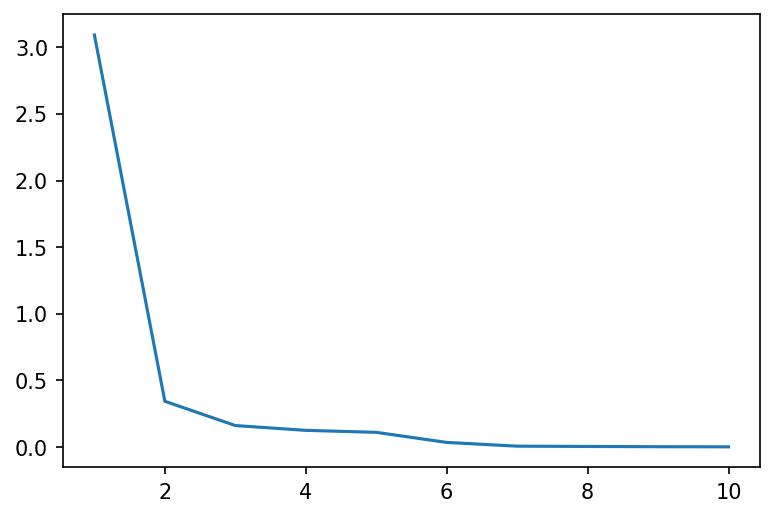

In [37]:
plt.plot(np.arange(num_PCs)+1, pca.explained_variance_)

In [54]:
df = mat.loc[mat.isnull().any(axis=1), mat.columns[mat.isnull().any()]].iloc[10:25]

In [39]:
np.unique(mat)

array([ 0.,  1., nan])

In [ ]:
mo

In [ ]:
moxi_df = pd.read_csv("/n/data1/hms/dbmi/farhat/ye12/who/analysis/Moxifloxacin/tiers=1.csv")

In [27]:
eigenvec_df = pd.read_csv(os.path.join(out_dir, drug, f"{model_prefix}_PC_{10}.csv"))
model_inputs = pd.read_csv(os.path.join(out_dir, drug, f"{model_prefix}.csv"), index_col=0)


# # drop any samples from the phenotypes and genotypes dataframes that are not in the eigenvector dataframe (some samples may not have genotypes)
# # reorder the phenotypes, genotypes, and eigevector dataframes so that they are all in the same sample order
# df_phenos = df_phenos.query("sample_id in @eigenvec_df.sample_id.values").sort_values("sample_id", ascending=True).reset_index(drop=True)
# model_inputs = model_inputs.query("sample_id in @eigenvec_df.sample_id.values").sort_values("sample_id", ascending=True).reset_index(drop=True)
# eigenvec_df = eigenvec_df.sort_values("sample_id", ascending=True).reset_index(drop=True)

# assert len(df_phenos) == len(eigenvec_df) == len(model_inputs)

# # set index for these 2 dataframes so that later only the values can be extracted
# model_inputs = model_inputs.set_index("sample_id")
# eigenvec_df = eigenvec_df.set_index("sample_id")

# think it makes more sense to scale first, then concatenate eigenvectors
scaler = StandardScaler()
X = scaler.fit_transform(model_inputs.dropna().values)

# concatenate the eigenvectors to the matrix
# X = np.concatenate([X, eigenvec_df.values], axis=1)
y = df_phenos.phenotype.values

#assert len(y) == X.shape[0]
print(X.mean(), X.std())

1.1604583339866103e-19 0.5392008571232709


In [30]:
X.shape, len(y)

((6866, 1166), 6946)

In [31]:
y = y[:6866]

In [36]:
y = pd.Series(y).map({"S": 0, "R": 1})

In [44]:
model = LogisticRegressionCV(Cs=1/np.logspace(-4, 4, 9), 
                             cv=5,
                             penalty='l2', 
                             max_iter=10000, 
                             multi_class='ovr',
                             scoring='neg_log_loss'
                            )

In [45]:
model.fit(X, y)


KeyboardInterrupt



In [43]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [12]:
test = pd.read_csv("/n/data1/hms/dbmi/farhat/ye12/who/analysis/Rifampicin/tiers_1.csv")

In [13]:
test

,sample_id,rpoB_c.-19A>C,rpoB_c.-19A>G,rpoB_c.-21G>C,rpoB_c.-29G>A,rpoB_c.-3A>G,rpoB_c.-40G>C,rpoB_c.-41A>G,rpoB_c.-42A>G,rpoB_c.-44C>T,...,rpoB_p.Val895Gln,rpoB_p.Val895Ile,rpoB_p.Val895Leu,rpoB_p.Val895Phe,rpoB_p.Val916Met,rpoB_p.Val946Gly,rpoB_p.Val970Ala,rpoB_p.Val970Met,rpoB_p.Val994Ala,rpoB_p.Val996Gly
0,4150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6984,705560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6985,705567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6986,705574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6987,705578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
np.unique(test.values)

array([0.00000e+00, 1.00000e+00, 4.15000e+03, ..., 7.05578e+05,
       7.05579e+05,         nan])

In [149]:
phenos = pd.read_csv("/n/data1/hms/dbmi/farhat/ye12/who/phenotypes/drug_name=Amikacin/run-1660066660338-part-r-00011")

In [148]:
dfs_list_phenos

[      sample_id     category phenotype
 0         13859  WHO_current         S
 1         15205  WHO_current         R
 2         20029  WHO_current         S
 3         34220  WHO_current         R
 4         34406  WHO_current         S
 ...         ...          ...       ...
 9219     812688  WHO_current         S
 9220     813965  WHO_current         S
 9221     814000  WHO_current         S
 9222     814040  WHO_current         S
 9223     814094  WHO_current         S
 
 [9224 rows x 3 columns]]

In [130]:
# create the phenotypes matrix
dfs_list_phenos = []

for fName in os.listdir(phenos_dir):
    dfs_list_phenos.append(pd.read_csv(os.path.join(phenos_dir, fName)))

df_phenos = pd.concat(dfs_list_phenos)
df_phenos["phenotype"] = df_phenos["phenotype"].map({'S': 0, 'R': 1})

In [108]:
eigenvec_df

,0,1,2,3,4,5,6,7,8,9,sample_id
0,0.000255,0.003944,-0.000536,-0.007373,0.004487,0.003540,0.002920,0.009190,0.007407,-0.001490,4150
1,0.000002,0.000572,-0.000433,-0.000836,0.001125,-0.001375,0.001256,0.004350,0.002873,-0.001933,12771
2,-0.017405,0.001169,-0.000331,-0.001042,0.000561,0.002029,-0.002121,-0.000268,0.000831,-0.000876,12788
3,-0.018160,0.000774,-0.001965,-0.000022,0.000162,-0.000097,-0.013529,0.001664,-0.000805,0.000199,12797
4,0.000589,-0.001554,-0.001452,0.004085,-0.001824,-0.005921,-0.001838,0.001069,-0.000831,0.001620,12803
...,...,...,...,...,...,...,...,...,...,...,...
6612,-0.018359,0.000239,-0.002686,-0.000213,-0.000506,-0.001314,0.029316,-0.007195,0.001025,-0.000539,741021
6613,-0.018441,0.000276,-0.002609,-0.000105,-0.000485,-0.001413,0.029648,-0.007515,0.001159,-0.000843,741023
6614,-0.018415,0.000205,-0.002603,-0.000077,-0.000347,-0.001608,0.029807,-0.006842,0.001160,-0.001376,741024
6615,-0.018495,0.000206,-0.002648,-0.000055,-0.000462,-0.001357,0.029911,-0.006314,0.001421,-0.000726,741025


In [111]:
# drop any samples from the phenotypes and genotypes dataframes that are not in the eigenvector dataframe (some samples may not have genotypes)
# reorder the phenotypes, genotypes, and eigevector dataframes so that they are all in the same sample order
df_phenos = df_phenos.query("sample_id in @eigenvec_df.sample_id.values").sort_values("sample_id", ascending=True).reset_index(drop=True)
model_inputs = model_inputs.query("sample_id in @eigenvec_df.sample_id.values").sort_values("sample_id", ascending=True).reset_index(drop=True)
eigenvec_df = eigenvec_df.sort_values("sample_id", ascending=True).reset_index(drop=True)

assert len(df_phenos) == len(eigenvec_df) == len(model_inputs)

# set index for these 2 dataframes so that later only the values can be extracted
filtered_matrix = model_inputs.set_index("sample_id")
eigenvec_df = eigenvec_df.set_index("sample_id")

In [112]:
filtered_matrix

,eis_c.-10G>A,eis_c.-10G>C,eis_c.-10_-3delGTCGGATT,eis_c.-12C>T,eis_c.-13A>C,eis_c.-13A>G,eis_c.-14C>T,eis_c.-15C>G,eis_c.-15C>T,eis_c.-16G>C,...,whiB7_p.Ser45Gly,whiB7_p.Ser78Asn,whiB7_p.Thr10_Gln13del,whiB7_p.Thr32Asn,whiB7_p.Trp63Leu,whiB7_p.Val17Gly,whiB7_p.Val38Leu,whiB7_p.Val44Leu,whiB7_p.Val65Phe,whiB7_p.Val91Gly
sample_id,,,,,,,,,,,,,,,,,,,,,
4150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12797,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741021,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
741023,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
741024,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
impute_cols = filtered_matrix.columns[filtered_matrix.isna().any()]
print(f"There are NaNs in {len(impute_cols)}/{filtered_matrix.shape[1]} genetic features")

for i, col in enumerate(impute_cols):
    
    # isolates without a genotype for thsi column
    missing_isolates = filtered_matrix.loc[pd.isnull(filtered_matrix[col]), :].index.values
    
    susc_isolates = df_phenos.query("phenotype == 0").sample_id.values
    resist_isolates = df_phenos.query("phenotype == 1").sample_id.values
    
    # take the average of the genotype across isolates of the same class
    susc_impute = filtered_matrix.loc[filtered_matrix.index.isin(susc_isolates), col].dropna().mean()
    resist_impute = filtered_matrix.loc[filtered_matrix.index.isin(resist_isolates), col].dropna().mean()
        
    for isolate in missing_isolates:
        
        if df_phenos.query("sample_id == @isolate").phenotype.values[0] == 1:
            filtered_matrix.loc[isolate, col] = resist_impute
        else:
            filtered_matrix.loc[isolate, col] = susc_impute
            
    if i % 100 == 0:
        print(i)

There are NaNs in 964/2144 genetic features
0
100
200
300
400
500
600
700
800
900


In [117]:
np.nan in np.unique(model_inputs.values)

False

In [119]:
sum(pd.isnull(np.unique(model_inputs.values)))

1

In [120]:
fNames = os.listdir("/n/data1/hms/dbmi/farhat/ye12/who/narrow_format")

In [122]:
dfs_lst = []
for fName in fNames:
    
    dfs_lst.append(pd.read_csv(os.path.join("/n/data1/hms/dbmi/farhat/ye12/who/narrow_format", fName)))

In [123]:
df_snps = pd.concat(dfs_lst)

In [132]:
len(df_phenos.sample_id.unique()), len(df_snps.sample_id.unique())

(9224, 58195)

In [137]:
df_phenos.sample_id.astype(str).values

array(['13859', '15205', '20029', ..., '814000', '814040', '814094'],
      dtype=object)

In [158]:
(model_inputs == 0).all(axis=1)

0       False
1       False
2       False
3       False
4       False
        ...  
6612    False
6613    False
6614    False
6615    False
6616    False
Length: 6617, dtype: bool

sample_id
4150       True
12771     False
12788     False
12797     False
12803      True
          ...  
741021    False
741023    False
741024    False
741025    False
741026    False
Length: 6617, dtype: bool

In [175]:
missing_genos = set(phenos.sample_id) - set(model_inputs.sample_id)

In [178]:
model_inputs.shape

(6617, 2145)

In [172]:
model_inputs.index[(model_inputs.set_index("sample_id") == 0).all(axis=1).values]

Int64Index([   0,    4,    5,    7,    8,    9,   11,   13,   14,   15,
            ...
            6586, 6588, 6589, 6593, 6594, 6596, 6599, 6603, 6609, 6610],
           dtype='int64', length=3921)

In [173]:
model_inputs.iloc[model_inputs.index[(model_inputs.set_index("sample_id") == 0).all(axis=1).values], :]

,sample_id,eis_c.-10G>A,eis_c.-10G>C,eis_c.-10_-3delGTCGGATT,eis_c.-12C>T,eis_c.-13A>C,eis_c.-13A>G,eis_c.-14C>T,eis_c.-15C>G,eis_c.-15C>T,...,whiB7_p.Ser45Gly,whiB7_p.Ser78Asn,whiB7_p.Thr10_Gln13del,whiB7_p.Thr32Asn,whiB7_p.Trp63Leu,whiB7_p.Val17Gly,whiB7_p.Val38Leu,whiB7_p.Val44Leu,whiB7_p.Val65Phe,whiB7_p.Val91Gly
0,4150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,13130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,13415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,13455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6596,740990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6599,740997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6603,741008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6609,741015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [167]:
(model_inputs.set_index("sample_id") == 0).all(axis=1).index

Int64Index([  4150,  12771,  12788,  12797,  12803,  13130,  13349,  13415,
             13455,  13540,
            ...
            741012, 741014, 741015, 741016, 741019, 741021, 741023, 741024,
            741025, 741026],
           dtype='int64', name='sample_id', length=6617)

In [151]:
missing_from_snp_matrices = set(phenos.sample_id.astype(str).values) - set(df_snps.sample_id.astype(str).values)

In [152]:
len(missing_from_snp_matrices)

2445

In [143]:
list(missing_from_snp_matrices)[0]

'808724'

In [144]:
df_phenos.query("sample_id == 808724")

,sample_id,category,phenotype
2462,808724,WHO_current,1


In [146]:
df_snps.query("sample_id == '808724'")

,sample_id,position,nucleotide


In [141]:
9224-2445

6779

In [114]:
np.unique(filtered_matrix.values)

array([0.00000000e+00, 1.71673820e-04, 1.71703297e-04, 1.71732784e-04,
       1.71762281e-04, 1.71791788e-04, 1.71821306e-04, 1.71850833e-04,
       1.71880371e-04, 1.71909919e-04, 1.71939477e-04, 1.71969046e-04,
       1.71998624e-04, 1.72028213e-04, 1.72057811e-04, 1.72087420e-04,
       1.72117040e-04, 1.72146669e-04, 1.72205958e-04, 1.72235618e-04,
       1.72294969e-04, 1.72354361e-04, 1.72384072e-04, 1.72413793e-04,
       1.72532781e-04, 1.72562554e-04, 3.43347639e-04, 3.43406593e-04,
       3.43465568e-04, 3.43524562e-04, 3.43583577e-04, 3.43701667e-04,
       3.43760743e-04, 3.43938091e-04, 3.43997248e-04, 3.44056425e-04,
       3.44115623e-04, 3.44174841e-04, 3.44234079e-04, 3.44352617e-04,
       3.44411917e-04, 3.44530577e-04, 3.44827586e-04, 3.45006038e-04,
       5.15021459e-04, 5.15109890e-04, 5.15198351e-04, 5.15375365e-04,
       5.15552500e-04, 5.16262261e-04, 5.16528926e-04, 5.16706855e-04,
       5.16884907e-04, 5.18045243e-04, 6.86695279e-04, 6.87049124e-04,
      

In [98]:
# think it makes more sense to scale first, then concatenate eigenvectors
scaler = StandardScaler()
X = scaler.fit_transform(model_inputs.values)

In [99]:
X

array([[-0.18080931, -0.05225498,  0.        , ...,  0.        ,
        -0.0122989 , -0.01739459],
       [-0.18080931, -0.05225498,  0.        , ...,  0.        ,
        -0.0122989 , -0.01739459],
       [-0.18080931, -0.05225498,  0.        , ...,  0.        ,
        -0.0122989 , -0.01739459],
       ...,
       [ 5.53068863, -0.05225498,  0.        , ...,  0.        ,
        -0.0122989 , -0.01739459],
       [ 5.53068863, -0.05225498,  0.        , ...,  0.        ,
        -0.0122989 , -0.01739459],
       [-0.18080931, -0.05225498,  0.        , ...,  0.        ,
        -0.0122989 , -0.01739459]])

In [100]:
# concatenate the eigenvectors to the matrix
X = np.concatenate([X, eigenvec_df.values], axis=1)
y = df_phenos.phenotype.values

In [101]:
X

array([[-1.80809311e-01, -5.22549761e-02,  0.00000000e+00, ...,
         9.18967872e-03,  7.40689862e-03, -1.48978827e-03],
       [-1.80809311e-01, -5.22549761e-02,  0.00000000e+00, ...,
         4.34981410e-03,  2.87341676e-03, -1.93254817e-03],
       [-1.80809311e-01, -5.22549761e-02,  0.00000000e+00, ...,
        -2.68269960e-04,  8.31372751e-04, -8.76398530e-04],
       ...,
       [ 5.53068863e+00, -5.22549761e-02,  0.00000000e+00, ...,
        -6.84246723e-03,  1.16027684e-03, -1.37633946e-03],
       [ 5.53068863e+00, -5.22549761e-02,  0.00000000e+00, ...,
        -6.31405580e-03,  1.42130960e-03, -7.26238363e-04],
       [-1.80809311e-01, -5.22549761e-02,  0.00000000e+00, ...,
         4.49535693e-03, -1.81600105e-03, -1.27329567e-04]])

In [102]:
assert len(y) == X.shape[0]
print(X.mean(), X.std())

nan nan


In [60]:
coef_df = pd.read_csv("/n/scratch3/users/s/sak0914/who/Amikacin/tiers_1_L2_coef.csv")
bs_coef = pd.read_csv("/n/scratch3/users/s/sak0914/who/Amikacin/tiers_1_coef_bs.csv")

In [61]:
def get_pvalues_add_ci(baseline_df, bs_df, col, ci=95):
    
    baseline_df[col] = baseline_df[col].astype(str)
    pvals = []
    for i, pos in enumerate(baseline_df[col].values):
        
        # get the percentile of 0
        ecdf = ECDF(bs_df[pos].values)
        zero_percentile = ecdf(0)
        
        # if the percentile is greater than 0.5, then the hypothesis test is for probability greater than 97.5
        # if the percentile i less than 0.5, then the hypothesis test is for probability less than 2.5
        if zero_percentile > 1 or zero_percentile < 0:
            print(pos)
        
        if zero_percentile < 0.5:
            pvals.append(2 * zero_percentile)
        else:
            pvals.append(2 * (1 - zero_percentile))
            
        # add confidence intervals
        diff = (100-ci)/2
        lower, upper = np.percentile(bs_df[pos].values, q=(diff, 100-diff))
        baseline_df.loc[i, "Lower_CI"] = lower
        baseline_df.loc[i, "Upper_CI"] = upper
        
    pvals = np.array(pvals)
    
    if len(np.unique(pvals)) > 1:
        min_non_zero = np.sort(np.unique(pvals))[1]
    else:
        min_non_zero = 1e-3
        
    # add Gaussian noise also so that the points aren't completely overlain
    #num_zero = len(np.where(pvals == 0)[0])
    
    # make sure that the maximum, which is exclusive, is alpha so that the random p values are smaller
    #pvals[pvals == 0] = np.random.uniform(alpha/10, alpha, num_zero)
    pvals[pvals == 0] = min_non_zero
    return pvals

In [ ]:
who_variants.loc[(who_variants.drug == 'AMI') & (who_variants.confidence.str.contains("|".join(["1", "2"])))]

,Unnamed: 0,drug,genome_index,confidence,gene,variant
1634,1,AMI,1473246,1) Assoc w R,rrs,rrs_a1401g
1635,2,AMI,2715346,1) Assoc w R,eis,eis_c-14t
1636,3,AMI,1473329,2) Assoc w R - Interim,rrs,rrs_g1484t
1637,4,AMI,1473247,2) Assoc w R - Interim,rrs,rrs_c1402t


In [87]:
coef_df.query("((Lower_CI > 0 & Upper_CI > 0) | (Lower_CI < 0 & Upper_CI < 0)) & significant == 1").sort_values("coef", ascending=False)

,variant,coef,Lower_CI,Upper_CI,pval,neg_log_pval,significant
892,rrs_n.1401A>G,1.614208,1.909865,2.213155,0.002,6.214608,1
6,eis_c.-14C>T,0.317066,0.313199,0.525553,0.002,6.214608,1
1035,rrs_n.1484G>T,0.197619,0.144174,0.725639,0.002,6.214608,1
894,rrs_n.1402C>T,0.109641,0.065518,0.205733,0.024,3.729701,1
3,eis_c.-12C>T,0.088236,0.111279,0.473829,0.010,4.605170,1
...,...,...,...,...,...,...,...
7,eis_c.-15C>G,-0.035978,-0.417507,-0.217469,0.002,6.214608,1
30,eis_c.-9T>C,-0.043518,-0.329105,-0.026032,0.004,5.521461,1
1910,rrs_n.878G>A,-0.045511,-0.632571,-0.089251,0.002,6.214608,1
1949,rrs_n.906A>G,-0.048511,-0.616622,-0.351080,0.002,6.214608,1


In [82]:
def volcano_plot(baseline_df, bs_df, col, alpha=0.05, exclude_lst=[], label_thresh=0, title_suffix="", saveFig=None):
        
    pvals = get_pvalues_add_ci(baseline_df, bs_df, "variant")
    baseline_df["pval"] = pvals
        
    baseline_df["neg_log_pval"] = -np.log(baseline_df["pval"])
    baseline_df["significant"] = (baseline_df["pval"] < alpha).astype(int)
    
    # verify input order
    assert len(bs_df.columns) == len(set(bs_df.columns).intersection(baseline_df[col].values))
    
    # only plot features with nonzero coefficients
    bs_df_nonZero = baseline_df.query("coef != 0")
    
    fig, ax = plt.subplots()
    sns.scatterplot(data=bs_df_nonZero.loc[~bs_df_nonZero[col].isin(exclude_lst)], x="coef", y="neg_log_pval", 
                    alpha=0.75,
                    hue="significant", 
                    s=30,
                    palette={1:"darkred", 0:"lightgray"},
                    ax=ax)

    ax.legend().set_visible(False)
    plt.title("Ridge Regression Coefficients and Bootstrapped\np-values" + title_suffix + f", α = {alpha}")
    sns.despine()
    
    if saveFig is not None:
        plt.savefig(saveFig, dpi=300, bbox_inches="tight")
    else:
        plt.show()
        
    return bs_df_nonZero

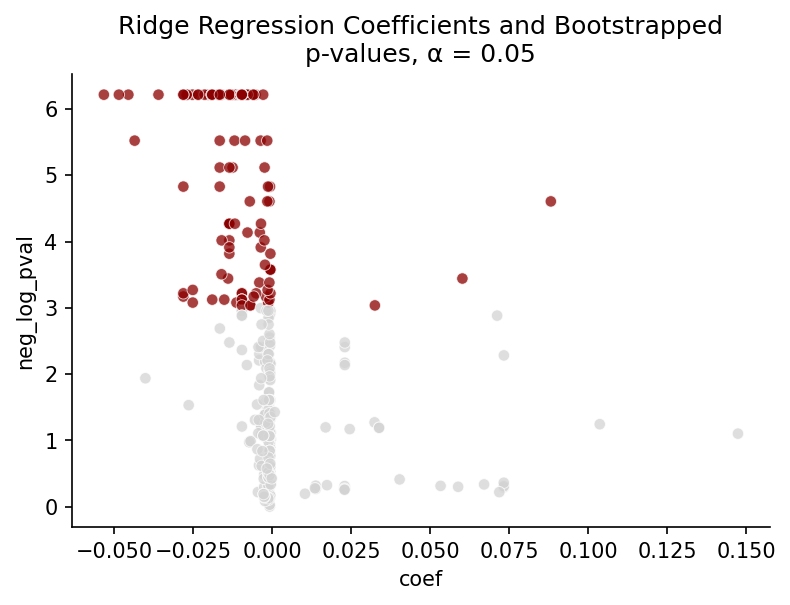

In [179]:
coef_nonZero = volcano_plot(coef_df, bs_coef, "variant", exclude_lst=['rrs_n.1401A>G', 'eis_c.-14C>T', 'rrs_n.1484G>T', 'rrs_n.1402C>T']
                            )

In [180]:
coef_nonZero

,variant,coef,Lower_CI,Upper_CI,pval,neg_log_pval,significant
0,eis_c.-10G>A,0.060231,0.020455,0.306228,0.032,3.442019,1
1,eis_c.-10G>C,-0.026411,-0.498180,0.014743,0.216,1.532477,0
3,eis_c.-12C>T,0.088236,0.111279,0.473829,0.010,4.605170,1
5,eis_c.-13A>G,-0.028106,-0.258962,-0.009997,0.008,4.828314,1
6,eis_c.-14C>T,0.317066,0.313199,0.525553,0.002,6.214608,1
...,...,...,...,...,...,...,...
2149,PC5,-0.000129,-0.152269,0.199505,0.652,0.427711,0
2150,PC6,-0.001523,-0.464885,-0.064993,0.010,4.605170,1
2151,PC7,-0.003525,-0.868909,-0.097941,0.014,4.268698,1
2152,PC8,-0.001646,-0.382903,0.386945,0.562,0.576253,0


# PRIORITY: Tier 1, Nonsynonymous mutations and mutations in noncoding regions. 

L2 regression because the feature selection has already been done by restricting to certain drugs.

# ALL OTHER ANALYSES ARE SECONDARY: 

## i.e. Including Tier 2 and synonymous variants would just be something that we do. 

### Other Notes

There are 2 more drugs with phenotype data than genotype data. What genes do we include for these 2?

The current WHO catalog doesn't have them, so can't select genes based on that either. COULD DO AN EXPLORATORY ANALYSIS USING THE FULL SNP MATRIX. 

Ofloxacin and Prothionamide

p = protein, c = non-coding

In [73]:
drug = 'Amikacin'
model_inputs_file = 'model_matrix_tiers_1.csv'
num_PCs = 10 
MAF = 0.01

# use MAF = 0.01 to filter genotypes for the GRM
num_PCs = int(num_PCs)
MAF = float(MAF)
model_inputs_file = model_inputs_file.split(".")[0]

# list of directories
tidy_dir = "/n/data1/hms/dbmi/farhat/ye12/who/narrow_format"
phenos_dir = '/n/data1/hms/dbmi/farhat/ye12/who/phenotypes'
phenos_dir = os.path.join(phenos_dir, f"drug_name={drug}")

###### STEP 0: READ IN THE PREVIOUSLY GENERATED PHENOTYPES MATRIX ######

model_inputs = pd.read_csv(f"/n/scratch3/users/s/sak0914/who/{drug}/{model_inputs_file}.csv")
eigenvec_fName = f"/n/scratch3/users/s/sak0914/who/{drug}/{model_inputs_file}_PC_{num_PCs}.csv"
eigenvec_df = pd.read_csv(eigenvec_fName)

In [80]:
model_inputs_imputed.to_csv(f"/n/scratch3/users/s/sak0914/who/{drug}/{model_inputs_file}.csv")

In [75]:
df_phenos = df_phenos.query("sample_id in @eigenvec_df.sample_id.values").sort_values("sample_id", ascending=True).reset_index(drop=True)
model_inputs = model_inputs.query("sample_id in @eigenvec_df.sample_id.values").sort_values("sample_id", ascending=True).reset_index(drop=True)
eigenvec_df = eigenvec_df.sort_values("sample_id", ascending=True).reset_index(drop=True)

assert len(df_phenos) == len(eigenvec_df) == len(model_inputs)

In [147]:
res = pd.read_csv("/n/scratch3/users/s/sak0914/who/Amikacin/model_matrix_tiers_1_L2_coef.csv")

# for num in np.arange(10):
    
#     num = str(num)
#     res = res.replace(f"PC_{num}", f"PC{num}")

res[["gene", "variant"]] = res.variant.str.split("_", n=1, expand=True)
res["variant"] = res["variant"].fillna(res["gene"])

res[["type", "variant"]] = res.variant.str.split(".", n=1, expand=True)
res["variant"] = res["variant"].fillna(res["type"])

In [164]:
res

,variant,coef,gene,type
0,-10G>A,0.060231,eis,c
1,-10G>C,-0.026411,eis,c
2,-10_-3delGTCGGATT,0.000000,eis,c
3,-12C>T,0.088236,eis,c
4,-13A>C,0.000000,eis,c
...,...,...,...,...
2149,PC5,-0.000129,PC5,PC5
2150,PC6,-0.001523,PC6,PC6
2151,PC7,-0.003525,PC7,PC7
2152,PC8,-0.001646,PC8,PC8


In [150]:
#res.loc[res.gene.str.contains('PC')]

In [159]:
for i, row in res.iterrows():
    
    if "PC" not in row["variant"]:
        
        # underscore separates start and end for indels
        if "_" not in row["variant"]:
            num = [char for char in row["variant"] if char.isnumeric()]

            # hyphen = negative position (upstream of CDS)
            if "-" in row["variant"]:
                res.loc[i, "pos"] = -int("".join(num))
            else:
                res.loc[i, "pos"] = int("".join(num))
            
        else:
            num1, num2 = row["variant"].split("_")
            num1 = [char for char in num1 if char.isnumeric()]
            num2 = [char for char in num2 if char.isnumeric()]
            
    else:
        res.loc[i, "pos"] = 0

In [161]:
res.loc[res.variant.str.contains("_")]

,variant,coef,gene,type,pos
2,-10_-3delGTCGGATT,0.000000,eis,c,-103
18,-382_-48del,0.000000,eis,c,-38248
19,-401_-48del,0.000000,eis,c,-40148
20,-404_-48del,0.000000,eis,c,-40448
23,-493_-9del,0.000000,eis,c,-4939
...,...,...,...,...,...
2081,-456_-11del,0.000000,whiB7,c,-45611
2082,-458_-14del,0.000000,whiB7,c,-45814
2089,-94_*350del,0.000000,whiB7,c,-94350
2111,Gly84_Arg87del,0.013559,whiB7,p,8487


,Unnamed: 0,drug,genome_index,confidence,gene,variant
1634,1,AMI,1473246,1) Assoc w R,rrs,rrs_a1401g
1635,2,AMI,2715346,1) Assoc w R,eis,eis_c-14t
1636,3,AMI,1473329,2) Assoc w R - Interim,rrs,rrs_g1484t
1637,4,AMI,1473247,2) Assoc w R - Interim,rrs,rrs_c1402t


In [ ]:
impute_cols = model_inputs.columns[model_inputs.isna().any()]
print(f"There are NaNs in {len(impute_cols)}/{model_inputs.shape[1]} columns")

There are NaNs in 964/2144 columns


In [ ]:
model_inputs_imputed = model_inputs.copy()

In [42]:
for i, col in enumerate(impute_cols):
    
    missing_isolates = model_inputs.loc[pd.isnull(model_inputs[col]), :].index.values
    
    susc_isolates = df_phenos.query("phenotype == 0").sample_id.values
    resist_isolates = df_phenos.query("phenotype == 1").sample_id.values
    
    # take the average of the genotype across isolates of the same class
    susc_impute = model_inputs.loc[model_inputs.index.isin(susc_isolates), col].dropna().mean()
    resist_impute = model_inputs.loc[model_inputs.index.isin(resist_isolates), col].dropna().mean()
        
    for isolate in missing_isolates:
        
        if df_phenos.query("sample_id == @isolate").phenotype.values[0] == 1:
            model_inputs_imputed.loc[isolate, col] = resist_impute
        else:
            model_inputs_imputed.loc[isolate, col] = susc_impute
            
    if i % 100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900


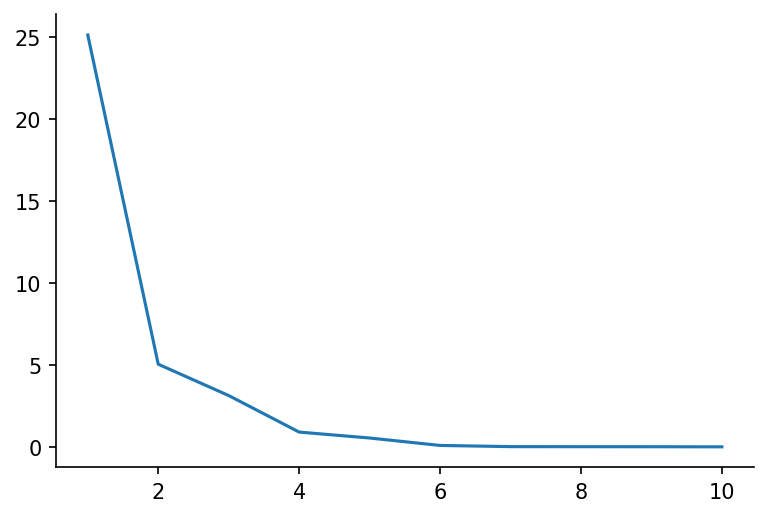

In [21]:
num_PCs = 20

plt.plot((np.arange(num_PCs)+1)[:10], [2.51460012e+01, 5.07554640e+00, 3.16458477e+00, 9.37567711e-01, 5.76453132e-01, 1.22809596e-01, 5.08587006e-02, 4.65348761e-02\
 ,4.45522854e-02, 3.85694086e-02, 3.67596718e-02, 2.77925521e-02
 ,2.24833116e-02, 1.99637827e-02, 1.77671691e-02, 1.67478761e-02
 ,1.19969868e-02, 8.04273705e-03, 6.81262956e-03, 5.37617281e-03][:10])
sns.despine()
plt.show()

# Processing Inputs for Model


1. Variant binary status:

<ul>
    <li>1 If the variant meets all QC criteria and AF>=75%,</li>
    <li>NA if the variant does not meet any QC criteria or AF <75%</li>
    <li>0 if the variant meets QC criteria, and the reference purity is >75%, i.e. AF<=25%</li>
</ul>

2. Variant allele frequency:

<ul>
    <li>AF for all variants that otherwise meet QC, and have AF >=25%</li>
    <li>0 if the variant otherwise meets QC, and has AF<=25%</li>
    <li>NA if the variant does not meet any of the other QC criteria</li>
</ul>
    
    
Tl;dr: If either column is NA, then that variant did not meet QC criteria. 
    
For the others, if `variant_binary_status == 1`, then the AF >= 75%, and the AF is recorded in the `variant_allele_frequency` column. 

If `variant_binary_status == 0`, then AF <= 25%. 

In [ ]:
df_test["QC"] = df_test["variant_binary_status"].map({1: 1, 0, 0})

In [106]:
df_test

,sample_id,gene_symbol,category,variant_allele_frequency,variant_binary_status
3,705376,rrs,n.1138A>C,0.0,0.0
7,705376,rrs,n.1304_*213del,0.0,0.0
11,705376,rrs,n.1144_1145insT,0.0,0.0
15,705376,rrs,n.1401A>G,0.0,0.0
19,705376,rrs,n.1235_1236delCCinsAT,0.0,0.0
...,...,...,...,...,...
32751,705530,rrs,n.305T>A,0.0,0.0
32755,705530,rrs,n.726_729delGTCTinsCTTC,0.0,0.0
32759,705530,rrs,n.364_930del,0.0,0.0
32763,705530,rrs,n.830_841delTCCTTCCTTGGGinsCCTTTTCACGGA,0.0,0.0


### Combine all runs for the same drug into a single giant matrix.
### Separate by gene
### Do the parsing by gene

In [87]:
def extract_variants(data_dir, phenos_file):
    '''
    For category c, a negative coordinate is how far upstream of the CDS the variant is.
    
    Remove indels and synonymous SNPs for now. Focus on nonsynonymous and noncoding mutations. 
    
    Synonymous: c, positive coordinate
    Nonsynonymous: p
    n = noncoding variants in rrs/rrl
    '''
                
    # p = nonsynonymous variant. Within-gene AA position
    # n = noncoding in rrs and rrl, c = synonymous or upstream variants. Within-gene nucleotide position
    # keep only positions that have a negative coordinate. Positive coordinate and n/c = synonymous mutation
    
    dfs_lst = []
    
    for i, fName in enumerate(glob.glob(os.path.join(data_dir, "*"))):
        
        print(f"Working on dataframe {i+1}")
        
        # read in the dataframe
        df = pd.read_csv(fName)
    
        df_avail_isolates = df.loc[df.sample_id.isin(phenos_file.sample_id)]
    
        # keep only the categories of interest and only samples with phenotypes available
        dfs_lst.append(df_avail_isolates.loc[((df_avail_isolates.category.astype(str).str[0] == 'c') & (df_avail_isolates.category.str.contains('-'))) | 
                                             (df_avail_isolates.category.astype(str).str[0].isin(['n', 'p']))])
        
    df_model = pd.concat(dfs_lst)
    
    # check that there are no 
    assert len(df_model.loc[(df_model.category.astype(str).str[0] == 'c') & (df_model.category.str.contains('|'.join(['ins', 'del']))) & ~(df_model.category.str.contains('-'))]) == 0
        
    return df_model

In [89]:
df_new = extract_variants("/n/data1/hms/dbmi/farhat/ye12/who/full_genotypes/drug_name=Amikacin/tier=1", ami_phenos)

Working on dataframe 1
Working on dataframe 2
Working on dataframe 3


In [73]:
df_tier1_AMI.shape

(69074648, 5)

In [74]:
len(df_tier1_AMI.category.unique())

2168

In [91]:
df_new.to_csv("/n/scratch3/users/s/sak0914/who/tier1_models/AMI/combined_variants.csv", index=False)

In [109]:
df_test = df_new.iloc[:100000, :]

In [110]:
df_test

,sample_id,gene_symbol,category,variant_allele_frequency,variant_binary_status
3,705376,rrs,n.1138A>C,0.0,0.0
7,705376,rrs,n.1304_*213del,0.0,0.0
11,705376,rrs,n.1144_1145insT,0.0,0.0
15,705376,rrs,n.1401A>G,0.0,0.0
19,705376,rrs,n.1235_1236delCCinsAT,0.0,0.0
...,...,...,...,...,...
763324,169329,rrs,n.1141_1145delCGTGAinsTGCAG,0.0,0.0
763328,169329,rrs,n.869_870delACinsGT,0.0,0.0
763332,169329,rrs,n.1144_1494del,0.0,0.0
763336,169329,rrs,n.870_871delCCinsTT,0.0,0.0


In [111]:
df_test.variant_binary_status.value_counts()

0.0    96330
1.0        9
Name: variant_binary_status, dtype: int64

In [105]:
df_test.variant_allele_frequency.unique()

array([0., 1.])

Amikacin,rrs,1
Amikacin,whiB7,1
Amikacin,eis,1

In [114]:
df_new.gene_symbol.unique()

array(['rrs', 'whiB7', 'eis'], dtype=object)

In [144]:
matrix = df_test.pivot(index="sample_id", columns="category", values='variant_binary_status')

In [145]:
matrix.shape

(56, 1812)

In [148]:
matrix.head()

category,n.-103_310del,n.-103_332del,n.-103_428del,n.-13G>A,n.-15_-14insT,n.-17_426del,n.-18C>T,n.-19_-18insC,n.-20_-19insTCCAAAGGGA,n.-20_-19insTCCAAAGGGAGTGTTTGGG,...,n.996_1003delGGACGCGTinsACC,n.997G>A,n.997_1005delGACGCGTCTinsAACTTAGC,n.998_1432del,n.999C>A,n.999C>T,n.999_1000delCGinsAA,n.999_1005delCGCGTCTinsAACATCC,n.999_1005delCGCGTCTinsAACGGCC,n.99G>A
sample_id,,,,,,,,,,,,,,,,,,,,,
14860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [166]:
#value_counts_df = matrix.apply(pd.Series.value_counts, dropna=False).fillna(0)
#filtered_indels = indels_new[value_counts_df.columns[((value_counts_df.loc[0.5, :] / value_counts_df.sum(axis=0)) <= 0.05)]]

# drop rows with too many NaNs
filtered_matrix = matrix[matrix.columns[(matrix.isnull().sum(axis=0) / matrix.shape[1] <= 0.05)]]
filtered_matrix = filtered_matrix.loc[filtered_matrix.index[(filtered_matrix.isnull().sum(axis=1) / filtered_matrix.shape[0] <= 0.05)], :]

filtered_matrix = filtered_matrix[filtered_matrix.columns[filtered_matrix.mean(axis=0) >= 0.01]]
#matrix = matrix[value_counts_df.columns[((value_counts_df.loc[0.5, :] / value_counts_df.sum(axis=0)) <= 0.05)]]

(50, 1812)

In [156]:
matrix.shape

(56, 1812)

In [174]:
drug = "AMI"
tier = '1'
os.path.join("/n/scratch3/users/s/sak0914/who", "tier" + tier + "_models", drug)

'/n/scratch3/users/s/sak0914/who/tier1_models/AMI'

In [ ]:
genos_dir, phenos_dir, MAF, tier, drug

In [ ]:
python3 WHO/make_model_inputs.py /n/data1/hms/dbmi/farhat/ye12/who/full_genotypes/drug_name=Amikacin/tier=1 /n/data1/hms/dbmi/farhat/ye12/who/phenotypes/drug_name=Amikacin 0.01 1 AMI

In [175]:
os.path.isdir("/n/scratch3/users/s/sak0914/who/tier1_models/AMI")

True

In [169]:
value_counts_df = filtered_matrix.apply(pd.Series.value_counts, dropna=False).fillna(0)

In [170]:
value_counts_df

category,n.-103_310del,n.-103_332del,n.-103_428del,n.-13G>A,n.-15_-14insT,n.-17_426del,n.-18C>T,n.-19_-18insC,n.-20_-19insTCCAAAGGGA,n.-20_-19insTCCAAAGGGAGTGTTTGGG,...,n.996_1003delGGACGCGTinsACC,n.997G>A,n.997_1005delGACGCGTCTinsAACTTAGC,n.998_1432del,n.999C>A,n.999C>T,n.999_1000delCGinsAA,n.999_1005delCGCGTCTinsAACATCC,n.999_1005delCGCGTCTinsAACGGCC,n.99G>A
0.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [171]:
filtered_matrix.mean(axis=0) >= 0.01

category
n.-103_310del                     False
n.-103_332del                     False
n.-103_428del                     False
n.-13G>A                          False
n.-15_-14insT                     False
                                  ...  
n.999C>T                          False
n.999_1000delCGinsAA              False
n.999_1005delCGCGTCTinsAACATCC    False
n.999_1005delCGCGTCTinsAACGGCC    False
n.99G>A                           False
Length: 1812, dtype: bool

In [133]:
matrix.isnull().sum(axis=1)

sample_id
14860       18
45424        0
50150        0
64670        0
64818        0
65218        0
65303        0
65375        0
141220       0
141367      19
141457       0
151571    1812
151605       0
164091       0
164097       0
164116       0
164132       0
164349       0
164486       0
164505       0
164518       1
164551       0
164572       0
164690       0
164826       0
165254       0
165434       0
165445       0
165492       0
165984       0
166083       0
166637       0
166952       0
166965       0
167086       0
167096       0
167098       0
167140       0
167168       0
167171       0
167188       0
167299       0
167305       0
167610       0
168601       0
169063       0
169319       0
169329    1217
169372       0
169399       0
705376     255
705423       0
705471       0
705496       0
705530       0
708358    1811
dtype: int64

In [132]:
matrix.loc[pd.isnull(14860)]

category,n.-103_310del,n.-103_332del,n.-103_428del,n.-13G>A,n.-15_-14insT,n.-17_426del,n.-18C>T,n.-19_-18insC,n.-20_-19insTCCAAAGGGA,n.-20_-19insTCCAAAGGGAGTGTTTGGG,...,n.996_1003delGGACGCGTinsACC,n.997G>A,n.997_1005delGACGCGTCTinsAACTTAGC,n.998_1432del,n.999C>A,n.999C>T,n.999_1000delCGinsAA,n.999_1005delCGCGTCTinsAACATCC,n.999_1005delCGCGTCTinsAACGGCC,n.99G>A
sample_id,,,,,,,,,,,,,,,,,,,,,
14860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
141220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


.apply(pd.Series.value_counts)

In [129]:
matrix.apply(pd.Series.value_counts)

category,n.-103_310del,n.-103_332del,n.-103_428del,n.-13G>A,n.-15_-14insT,n.-17_426del,n.-18C>T,n.-19_-18insC,n.-20_-19insTCCAAAGGGA,n.-20_-19insTCCAAAGGGAGTGTTTGGG,...,n.996_1003delGGACGCGTinsACC,n.997G>A,n.997_1005delGACGCGTCTinsAACTTAGC,n.998_1432del,n.999C>A,n.999C>T,n.999_1000delCGinsAA,n.999_1005delCGCGTCTinsAACATCC,n.999_1005delCGCGTCTinsAACGGCC,n.99G>A
sample_id,,,,,,,,,,,,,,,,,,,,,
14860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
141220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# remove isolates and positions with too much missingness 
filtered_matrix = matrix[value_counts_df.columns[((value_counts_df.loc[0.5, :] / value_counts_df.sum(axis=0)) <= 0.05)]]

In [126]:
value_counts_df

category,n.-103_310del,n.-103_332del,n.-103_428del,n.-13G>A,n.-15_-14insT,n.-17_426del,n.-18C>T,n.-19_-18insC,n.-20_-19insTCCAAAGGGA,n.-20_-19insTCCAAAGGGAGTGTTTGGG,...,n.996_1003delGGACGCGTinsACC,n.997G>A,n.997_1005delGACGCGTCTinsAACTTAGC,n.998_1432del,n.999C>A,n.999C>T,n.999_1000delCGinsAA,n.999_1005delCGCGTCTinsAACATCC,n.999_1005delCGCGTCTinsAACGGCC,n.99G>A
0.0,53.0,53.0,54.0,53.0,54.0,54.0,54.0,53.0,53.0,54.0,...,52.0,53.0,54.0,53.0,52.0,53.0,53.0,53.0,53.0,53.0
0.5,3.0,3.0,2.0,3.0,2.0,2.0,2.0,3.0,3.0,2.0,...,4.0,3.0,2.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [128]:
value_counts_df.sum(axis=0)

category
n.-103_310del                     56.0
n.-103_332del                     56.0
n.-103_428del                     56.0
n.-13G>A                          56.0
n.-15_-14insT                     56.0
                                  ... 
n.999C>T                          56.0
n.999_1000delCGinsAA              56.0
n.999_1005delCGCGTCTinsAACATCC    56.0
n.999_1005delCGCGTCTinsAACGGCC    56.0
n.99G>A                           56.0
Length: 1812, dtype: float64

In [124]:
matrix["n.-103_310del"].value_counts()

0.0    53
0.5     3
Name: n.-103_310del, dtype: int64

In [82]:
ami_phenos = pd.read_csv("/n/data1/hms/dbmi/farhat/ye12/who/phenotypes/drug_name=Amikacin/run-1660066660338-part-r-00011")

In [92]:
len(pd.isnull(ami_phenos.phenotype))

9224

In [83]:
df_tier1_AMI_phenos = df_tier1_AMI.loc[df_tier1_AMI.sample_id.isin(ami_phenos.sample_id)]

In [84]:
df_tier1_AMI_phenos.shape

(14855136, 5)

In [90]:
df_new.shape

(14855136, 5)

In [85]:
69074648-14855136

54219512

In [86]:
ami_phenos

,sample_id,category,phenotype
0,13859,WHO_current,S
1,15205,WHO_current,R
2,20029,WHO_current,S
3,34220,WHO_current,R
4,34406,WHO_current,S
...,...,...,...
9219,812688,WHO_current,S
9220,813965,WHO_current,S
9221,814000,WHO_current,S
9222,814040,WHO_current,S


In [ ]:
os.path.dirname("/n/data1/hms/dbmi/farhat/ye12/who/full_genotypes/drug_name=Amikacin/tier=1")

In [77]:
len(df_tier1_AMI.sample_id.unique())

31861

In [65]:
test.shape

(11501821, 5)

In [66]:
len(test.category.unique())

361

In [56]:
df_model = extract_variants(test)

In [57]:
df_model.shape

(8506887, 5)

In [51]:
df_model.shape

(8506887, 5)

In [ ]:
assert len(test.loc[(test.category.astype(str).str[0] == 'c') & (test.category.str.contains('|'.join(['ins', 'del']))) & ~(test.category.str.contains('-'))]) == 0

In [64]:
test.loc[(test.category.astype(str).str[0] == 'c') & (test.category.str.contains('|'.join(['ins', 'del']))) & ~(test.category.str.contains('-'))]

,sample_id,gene_symbol,category,variant_allele_frequency,variant_binary_status


In [63]:
test.loc[(test.category.astype(str).str[0] == 'c') & (test.category.str.contains('|'.join(['ins', 'del'])))]

,sample_id,gene_symbol,category,variant_allele_frequency,variant_binary_status
67,56054,eis,c.-401_-48del,0.0,0.0
97,22451,eis,c.-401_-48del,0.0,0.0
136,178582,eis,c.-382_-48del,0.0,0.0
269,22451,eis,c.-24delCinsTT,0.0,0.0
326,169703,eis,c.-8delC,0.0,0.0
...,...,...,...,...,...
11501499,56816,eis,c.-24delCinsTT,0.0,0.0
11501531,56816,eis,c.-8delC,0.0,0.0
11501646,57034,eis,c.-493_-9del,0.0,0.0
11501705,57034,eis,c.-54_-37delGTCGTCGTAATATTCACG,0.0,0.0


In [62]:
df_model.loc[(df_model.category.astype(str).str[0] == 'p') & (df_model.category.str.contains('|'.join(['ins', 'del'])))]

,sample_id,gene_symbol,category,variant_allele_frequency,variant_binary_status
5,22451,eis,p.Arg172_Asn373del,0.0,0.0
11,56054,eis,p.Leu97_Gly327delinsArg,0.0,0.0
16,178582,eis,p.Thr231_Glu401del,0.0,0.0
21,22451,eis,p.Gly53_Ala248del,0.0,0.0
28,178582,eis,p.Gly73_Asp221del,0.0,0.0
...,...,...,...,...,...
11501809,57034,eis,p.Leu19_Arg172del,0.0,0.0
11501814,57034,eis,p.Arg98_Leu235del,0.0,0.0
11501816,57034,eis,p.Asp110_Val228del,0.0,0.0
11501818,57034,eis,p.Cys250del,0.0,0.0


In [61]:
df_model.loc[(df_model.category.astype(str).str[0] == 'n')]

,sample_id,gene_symbol,category,variant_allele_frequency,variant_binary_status


In [59]:
df_model.loc[(df_model.category.astype(str).str[0] == 'c')]

,sample_id,gene_symbol,category,variant_allele_frequency,variant_binary_status
19,56054,eis,c.-8C>T,0.0,0.0
30,169703,eis,c.-13A>G,0.0,0.0
36,178582,eis,c.-12C>T,0.0,0.0
38,169703,eis,c.-51G>A,0.0,0.0
44,178582,eis,c.-37G>T,0.0,0.0
...,...,...,...,...,...
11501749,57034,eis,c.-14C>T,0.0,0.0
11501777,57034,eis,c.-12C>T,0.0,0.0
11501779,57034,eis,c.-2C>A,0.0,0.0
11501783,57034,eis,c.-10G>C,0.0,0.0


In [52]:
test.shape

(11501821, 5)

In [48]:
test.loc[(test.category.astype(str).str[0].isin(['n', 'c']))]

,sample_id,gene_symbol,category,variant_allele_frequency,variant_binary_status
0,9285,eis,c.516C>T,0.0,0.0
3,56054,eis,c.849A>C,0.0,0.0
9,22451,eis,c.234G>A,0.0,0.0
17,22451,eis,c.418C>T,0.0,0.0
19,56054,eis,c.-8C>T,0.0,0.0
...,...,...,...,...,...
11501803,57034,eis,c.240C>T,0.0,0.0
11501806,57034,eis,c.144C>T,0.0,0.0
11501811,57034,eis,c.-404_-48del,0.0,0.0
11501813,57034,eis,c.537C>T,0.0,0.0


In [ ]:
test.shape

In [26]:
test.gene_symbol.unique()

array(['eis'], dtype=object)

In [35]:
test.loc[test.category.str.contains("ins")]

,sample_id,gene_symbol,category,variant_allele_frequency,variant_binary_status
11,56054,eis,p.Leu97_Gly327delinsArg,0.0,0.0
72,178582,eis,p.Ser121_Trp289delinsArg,0.0,0.0
100,178582,eis,p.Leu97_Glu199delinsGln,0.0,0.0
118,169703,eis,p.Arg98_Ala363delinsPro,0.0,0.0
147,56054,eis,p.Leu97_Asp273delinsHis,0.0,0.0
...,...,...,...,...,...
11501683,57034,eis,p.Leu97_Asp273delinsHis,0.0,0.0
11501684,57034,eis,p.Phe149_His150insThrProThrLeuArgAlaLeu,0.0,0.0
11501713,57034,eis,p.Ser121_Trp289delinsArg,0.0,0.0
11501782,57034,eis,p.Thr245_Leu356delinsMet,0.0,0.0


In [19]:
test.loc[test.category.astype(str).str[0] == 'c', :]

,sample_id,gene_symbol,category,variant_allele_frequency,variant_binary_status
0,9285,eis,c.516C>T,0.0,0.0
3,56054,eis,c.849A>C,0.0,0.0
9,22451,eis,c.234G>A,0.0,0.0
17,22451,eis,c.418C>T,0.0,0.0
19,56054,eis,c.-8C>T,0.0,0.0
...,...,...,...,...,...
11501803,57034,eis,c.240C>T,0.0,0.0
11501806,57034,eis,c.144C>T,0.0,0.0
11501811,57034,eis,c.-404_-48del,0.0,0.0
11501813,57034,eis,c.537C>T,0.0,0.0


In [25]:
Seq.translate("CGA"), Seq.translate("CGC")

('R', 'R')

In [32]:
start, end, sense = tb_genes.query("Symbol=='eis'")[["Start", "End", "Strand"]].values[0]

In [34]:
start, end, sense

(2714124, 2715332, '-')

In [15]:
314*3

942

In [16]:
test.loc[pd.isnull(test.variant_allele_frequency)]

,sample_id,gene_symbol,category,variant_allele_frequency,variant_binary_status
884326,53576,eis,c.-12C>T,NaN,NaN
884330,53576,eis,c.-15C>T,NaN,NaN
884334,53576,eis,c.216T>C,NaN,NaN
884338,53576,eis,c.27C>T,NaN,NaN
884342,53576,eis,p.Gly326Asp,NaN,NaN
...,...,...,...,...,...
11007768,144374,eis,p.Arg106Cys,NaN,NaN
11007769,144374,eis,p.Arg212Cys,NaN,NaN
11007770,144374,eis,p.Asp110_Val228del,NaN,NaN
11007771,144374,eis,p.Gly112Ser,NaN,NaN


In [7]:
test_na = test.loc[pd.isnull(test.variant_binary_status)]
print(test_na.shape, test_na.query("variant_allele_frequency >= 0.75").shape)

(8792, 5) (2, 5)


In [11]:
test_ref = test.query("variant_binary_status == 0")

In [15]:
test_ref.loc[pd.isnull(test_ref.variant_allele_frequency)]

,sample_id,gene_symbol,category,variant_allele_frequency,variant_binary_status


In [ ]:
test.loc

In [160]:
test.query("sample_id==9285").variant_binary_status.value_counts()

0.0    361
Name: variant_binary_status, dtype: int64

In [161]:
test.query("sample_id==9285")

,sample_id,gene_symbol,category,variant_allele_frequency,variant_binary_status
0,9285,eis,c.516C>T,0.0,0.0
7088581,9285,eis,c.-23G>T,0.0,0.0
7088587,9285,eis,p.Arg183Leu,0.0,0.0
7088593,9285,eis,c.105C>G,0.0,0.0
7088599,9285,eis,p.Asp281Gly,0.0,0.0
...,...,...,...,...,...
7090711,9285,eis,c.-12C>T,0.0,0.0
7090717,9285,eis,p.Ala304Val,0.0,0.0
7090723,9285,eis,p.Gly132Ala,0.0,0.0
7090729,9285,eis,p.Leu97_Glu199delinsGln,0.0,0.0


In [6]:
test.loc[test.category.str.contains("lof")]

,sample_id,gene_symbol,category,variant_allele_frequency,variant_binary_status
4,178582,eis,lof,0.0,0.0
113,22451,eis,lof,0.0,0.0
214,169703,eis,lof,0.0,0.0
339,56054,eis,lof,0.0,0.0
1260,178886,eis,lof,0.0,0.0
...,...,...,...,...,...
11500194,56769,eis,lof,0.0,0.0
11500677,56787,eis,lof,0.0,0.0
11501157,56789,eis,lof,0.0,0.0
11501266,56816,eis,lof,0.0,0.0


In [162]:
all_sites = np.load("/n/scratch3/users/s/sak0914/who/20220817_SNP_sites.npy")

In [164]:
len(all_sites)

7580

In [188]:
def get_bounds_for_gene(gene, all_sites):
    
    single_region_df = pos_df.query("region == @gene")

    prev_nc_region = pos_df.loc[single_region_df.index.values[0]-1, 'region']
    next_nc_region = pos_df.loc[single_region_df.index.values[-1]+1, 'region']

    assert int(prev_nc_region.split("_")[1]) + 1 == int(next_nc_region.split("_")[1])

    lower_bound, upper_bound = pos_df.query("region in [@gene, @prev_nc_region, @next_nc_region]").pos.values[[0, -1]]
    
    # return list of SNP sites within the gene of interest and its upstream and downstream noncoding regions
    return all_sites[np.where((all_sites >= lower_bound) & (all_sites <= upper_bound))[0]]

In [190]:
gene = 'eis'
get_bounds_for_gene(gene, all_sites)

array([2713795, 2714846, 2715342, 2715344])

'NC_1871'

In [4]:
test.query("variant_allele_frequency > 0 & variant_binary_status == 0")

,sample_id,gene_symbol,category,variant_allele_frequency,variant_binary_status


In [5]:
test.query("variant_allele_frequency == 0 & variant_binary_status > 0")

,sample_id,gene_symbol,category,variant_allele_frequency,variant_binary_status


In [7]:
test.variant_binary_status.value_counts()

0.0    11489761
1.0        3268
Name: variant_binary_status, dtype: int64

In [154]:
test.query("variant_allele_frequency > 0")

,sample_id,gene_symbol,category,variant_allele_frequency,variant_binary_status
13501,34728,eis,c.-10G>A,1.00,1.0
14681,34830,eis,c.-10G>A,1.00,1.0
16307,57197,eis,p.Thr70Ala,1.00,1.0
17299,57220,eis,p.Thr70Ala,0.98,1.0
30030,173016,eis,c.-10G>A,0.98,1.0
...,...,...,...,...,...
11469267,19618,eis,lof,0.89,1.0
11472345,34307,eis,c.-14C>T,1.00,1.0
11474221,34769,eis,c.-10G>A,1.00,1.0
11491339,54836,eis,p.Val163Ile,1.00,1.0
